# **Painting classification**

Our project aim to automatically classify/cluster paintings from famous painters (around 100 painters) into art movements (e.g., classicism, impressionism, cubism) using deep learning methods.

The main goal is to take a painting and associate a style with it and represent all the styles on a graph or with any other suitable representation.

---

### **Import libraries**

In [ ]:
import os
import glob
import shutil
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import itertools
import tensorflow as tf

from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from scipy.stats import chi2


if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor


print(device)

cuda


### **Import DATA**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
Working_directory= '/content/drive/My Drive/painting_project/data'

In [ ]:
painters = [name for name in os.listdir(Working_directory) if os.path.isdir(os.path.join(Working_directory, name))] #liste des peintres

images_by_painter = {} #dictionnaire image/vrai nom

image_names = []
painter_names = []
painter_names_full = []
bdates = []

for painter in painters:
    painter_path = os.path.join(Working_directory, painter)
    image_paths = glob.glob(os.path.join(painter_path, '*'))
    images_by_painter[painter] = image_paths
    for image_path in image_paths:
      image_name = os.path.basename(image_path)
      image_names.append(image_name)
      painter_names.append(painter.split(' - ')[0]) # ne garder que le nom de l'auteur
      painter_names_full.append(painter)
      bdates.append(int(painter.split('_')[1]))

df = pd.DataFrame({
    'image_name': image_names,
    'painter': painter_names,
    'date' : bdates
})

df.head()


image_name   painter  date
0  vasarely_7.jpg  vasarely  1906
1  vasarely_8.jpg  vasarely  1906
2  vasarely_1.jpg  vasarely  1906
3  vasarely_2.jpg  vasarely  1906
4  vasarely_3.jpg  vasarely  1906

Let's print an histogram to show how represented each painter is.


<Axes: xlabel='painter'>

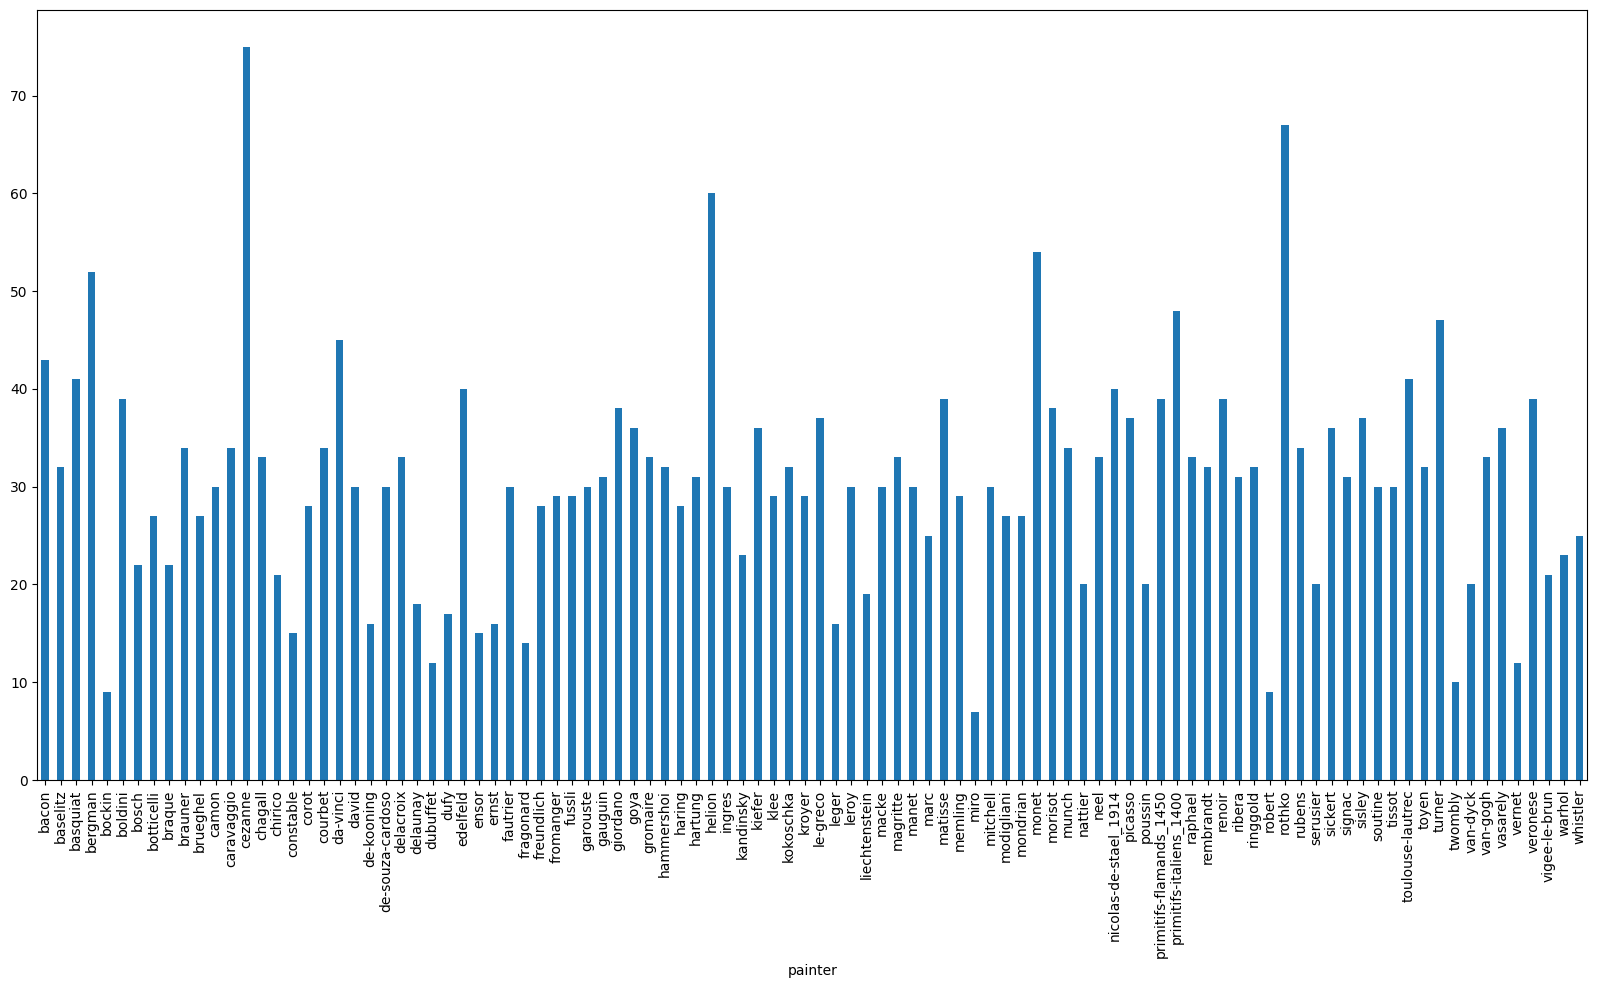

In [ ]:
df['image_name'].groupby(df['painter']).count().plot(kind='bar',figsize=(20,10))

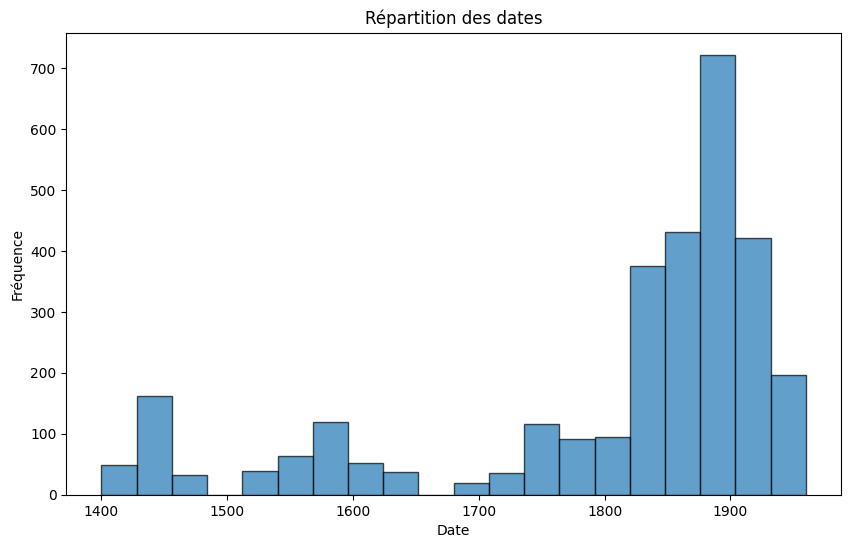

In [ ]:
df['date'] = pd.to_numeric(df['date'], errors='coerce')

# Afficher la répartition des dates avec un histogramme
plt.figure(figsize=(10, 6))
plt.hist(df['date'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Répartition des dates')
plt.xlabel('Date')
plt.ylabel('Fréquence')
plt.show()

We can see that the distribution over time is pretty unequal. We will thus need some normalization techniques.


### **Classification on Painter using ResNet**

#### **Define Weighted Metrics**

We first define a function calculate weights for each painter in order to avoid over representation of one of them during classification.

In [ ]:
def calculate_class_weights(y_true, nb_classes):
    N = len(y_true)
    G = [np.count_nonzero(y_true == i) for i in range(nb_classes)]
    weights = [N / (nb_classes * G_i) if G_i != 0 else 0 for G_i in G]
    return weights


#### **Prep Data**

##### Resize Method

As the ResNet Model requires a (224,224) entry, we have to modify the shape of each painting. In this section, we have simply resize all object and normalize them as it has been seen in a Lab Work.

In [ ]:
normalise_resize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalisation
])

def format_image(img_file):
	"""
	This function reads and formats an image so that it can be fed to the VGG16 networks

	Parameters
	----------
	img_file : image file name

	Returns
	-------
	img_out_model : the correctly formatted image for VGG16 or inceptionv3 networks
	img : the image as read by the load_img function of keras.preprocessing.image
	"""
	# read image
	img = Image.open(img_file)
	img_tensor = normalise_resize(img).unsqueeze(axis=0)
	img_np = np.array(img)

	return img_tensor, img_np

def unformat_image(img_in):
	"""
	This function inverts the preprocessing applied to images for use in the VGG16/inceptionv3 network

	Parameters
	----------
	img_file : formatted image of shape (batch_size,m,n,3)

	Returns
	-------
	img_out : a m-by-n-by-3 array, representing an image that can be written to an image file
	"""

	img_in = np.transpose(img_in.detach().numpy().squeeze(),[1,2,0])
	# invert the mean and standard deviation
	mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
	std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
	img_out = std * img_in + mean
	img_out *= 255
	img_out = np.uint8(np.clip(img_out, 0, 255))

	return img_out

#### **Create Tensors**

In [ ]:
X = [] #Image Tensor
Y = [] #labels

label_to_int = {label: idx for idx, label in enumerate(df['painter'].unique())} #change painter as

for n in range(len(image_names)):
    print(f'Step {n+1}/',len(image_names))

    img_path = os.path.join(Working_directory, painter_names_full[n], df.iloc[n]['image_name'])
    img_tensor, _ = format_image(img_path)

    X.append(img_tensor)
    Y.append(label_to_int[df.iloc[n]['painter']])

Step 1/ 3060
Step 2/ 3060
Step 3/ 3060
Step 4/ 3060
Step 5/ 3060
Step 6/ 3060
Step 7/ 3060
Step 8/ 3060
Step 9/ 3060
Step 10/ 3060
Step 11/ 3060
Step 12/ 3060
Step 13/ 3060
Step 14/ 3060
Step 15/ 3060
Step 16/ 3060
Step 17/ 3060
Step 18/ 3060
Step 19/ 3060
Step 20/ 3060
Step 21/ 3060
Step 22/ 3060
Step 23/ 3060
Step 24/ 3060
Step 25/ 3060
Step 26/ 3060
Step 27/ 3060
Step 28/ 3060
Step 29/ 3060
Step 30/ 3060
Step 31/ 3060
Step 32/ 3060
Step 33/ 3060
Step 34/ 3060
Step 35/ 3060
Step 36/ 3060
Step 37/ 3060
Step 38/ 3060
Step 39/ 3060
Step 40/ 3060
Step 41/ 3060
Step 42/ 3060
Step 43/ 3060
Step 44/ 3060
Step 45/ 3060
Step 46/ 3060
Step 47/ 3060
Step 48/ 3060
Step 49/ 3060
Step 50/ 3060
Step 51/ 3060
Step 52/ 3060
Step 53/ 3060
Step 54/ 3060
Step 55/ 3060
Step 56/ 3060
Step 57/ 3060
Step 58/ 3060
Step 59/ 3060
Step 60/ 3060
Step 61/ 3060
Step 62/ 3060
Step 63/ 3060
Step 64/ 3060
Step 65/ 3060
Step 66/ 3060
Step 67/ 3060
Step 68/ 3060
Step 69/ 3060
Step 70/ 3060
Step 71/ 3060
Step 72/ 3060
S

Then we split the dataset into Training, Validation and Test Set. I used the validation to change the model while training before testing it on the test one.

In [ ]:
X_tensor = torch.cat(X, dim=0)
Y_tensor = torch.tensor(Y, dtype=torch.long)

X_train, X_test, Y_train, Y_test = train_test_split(X_tensor,Y_tensor, test_size=0.15)
x_test, x_val, y_test, y_val = train_test_split(X_test, Y_test, test_size=0.5)

## **Resnet Model**

### **Define Model**

We use the pre-trained ResNet Model to which we had some layers in order to fine-tune him. After several tries and some researches, we found that adding 2 Dense Layers with one RELU between works best.

In [ ]:
num_classes = len(set(df['painter'][:len(X)]))
model_name = 'resnet'

resnet = models.resnet18(weights=models.ResNet18_Weights) #resnet18 trained on ImageNEt


for param in resnet.parameters():
    param.requires_grad = False

n_features = resnet.fc.in_features

resnet.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(n_features, 256),
    nn.ReLU(),
    #nn.Dropout(p=0.5),
    nn.Linear(256, num_classes)
)




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 104MB/s]


In [ ]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### **Train**

In [ ]:
y_train_np = Y_train.cpu().numpy()
class_weights = calculate_class_weights(y_train_np, nb_classes=100) #we had 100 painters
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

In [ ]:
optimizer = torch.optim.Adam(resnet.fc.parameters(),lr=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_L = [] #keep losses
val_L = [] #keep losses
model = resnet
model = model.to(device)

n_epoch = 40

for epoch in range(n_epoch):
    model.train()
    running_loss = 0.0
    train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epoch}', unit='batch')

    for inputs, targets in train_loader_tqdm:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        train_loader_tqdm.set_postfix(train_loss=running_loss / len(train_loader.dataset))

    # Evaluation on Validation Set
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        val_loader_tqdm = tqdm(val_loader, desc='Validating', unit='batch')
        for inputs, targets in val_loader_tqdm:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

        val_loader_tqdm.set_postfix(val_loss=val_loss / len(val_loader.dataset), val_acc=(correct / total) * 100)

    train_L.append(running_loss/len(train_loader.dataset))
    val_L.append(val_loss/len(val_loader.dataset))
    print(f"Epoch {epoch+1}/{n_epoch}, Train Loss: {running_loss/len(train_loader.dataset):.4f}, Val Loss: {val_loss/len(val_loader.dataset):.4f}, Val Acc: {(correct/total)*100:.2f}%")



Validating: 100%|██████████| 8/8 [00:00<00:00, 21.38batch/s]


Epoch 1/40, Train Loss: 4.6021, Val Loss: 4.5658, Val Acc: 2.61%


Validating: 100%|██████████| 8/8 [00:00<00:00, 33.38batch/s]


Epoch 2/40, Train Loss: 4.4516, Val Loss: 4.4316, Val Acc: 6.96%


Validating: 100%|██████████| 8/8 [00:00<00:00, 32.82batch/s]


Epoch 3/40, Train Loss: 4.2729, Val Loss: 4.2592, Val Acc: 9.13%


Validating: 100%|██████████| 8/8 [00:00<00:00, 28.77batch/s]


Epoch 4/40, Train Loss: 4.0622, Val Loss: 4.0919, Val Acc: 16.09%


Validating: 100%|██████████| 8/8 [00:00<00:00, 33.52batch/s]


Epoch 5/40, Train Loss: 3.8377, Val Loss: 3.9291, Val Acc: 23.04%


Validating: 100%|██████████| 8/8 [00:00<00:00, 33.05batch/s]


Epoch 6/40, Train Loss: 3.6088, Val Loss: 3.7291, Val Acc: 23.04%


Validating: 100%|██████████| 8/8 [00:00<00:00, 31.80batch/s]


Epoch 7/40, Train Loss: 3.3881, Val Loss: 3.5694, Val Acc: 26.96%


Validating: 100%|██████████| 8/8 [00:00<00:00, 31.84batch/s]


Epoch 8/40, Train Loss: 3.1996, Val Loss: 3.4509, Val Acc: 32.61%


Validating: 100%|██████████| 8/8 [00:00<00:00, 32.47batch/s]


Epoch 9/40, Train Loss: 3.0234, Val Loss: 3.3101, Val Acc: 35.65%


Validating: 100%|██████████| 8/8 [00:00<00:00, 32.89batch/s]


Epoch 10/40, Train Loss: 2.8629, Val Loss: 3.1729, Val Acc: 36.96%


Validating: 100%|██████████| 8/8 [00:00<00:00, 31.91batch/s]


Epoch 11/40, Train Loss: 2.7273, Val Loss: 3.0762, Val Acc: 37.39%


Validating: 100%|██████████| 8/8 [00:00<00:00, 31.18batch/s]


Epoch 12/40, Train Loss: 2.5989, Val Loss: 2.9626, Val Acc: 39.13%


Validating: 100%|██████████| 8/8 [00:00<00:00, 32.65batch/s]


Epoch 13/40, Train Loss: 2.4802, Val Loss: 2.8854, Val Acc: 37.83%


Validating: 100%|██████████| 8/8 [00:00<00:00, 33.36batch/s]


Epoch 14/40, Train Loss: 2.3795, Val Loss: 2.8396, Val Acc: 39.57%


Validating: 100%|██████████| 8/8 [00:00<00:00, 33.27batch/s]


Epoch 15/40, Train Loss: 2.2829, Val Loss: 2.7765, Val Acc: 41.30%


Validating: 100%|██████████| 8/8 [00:00<00:00, 32.22batch/s]


Epoch 16/40, Train Loss: 2.1928, Val Loss: 2.7025, Val Acc: 39.57%


Validating: 100%|██████████| 8/8 [00:00<00:00, 32.80batch/s]


Epoch 17/40, Train Loss: 2.0992, Val Loss: 2.6454, Val Acc: 42.61%


Validating: 100%|██████████| 8/8 [00:00<00:00, 32.05batch/s]


Epoch 18/40, Train Loss: 2.0309, Val Loss: 2.5945, Val Acc: 42.17%


Validating: 100%|██████████| 8/8 [00:00<00:00, 32.93batch/s]


Epoch 19/40, Train Loss: 1.9647, Val Loss: 2.5681, Val Acc: 40.87%


Validating: 100%|██████████| 8/8 [00:00<00:00, 31.85batch/s]


Epoch 20/40, Train Loss: 1.8966, Val Loss: 2.5325, Val Acc: 43.04%


Validating: 100%|██████████| 8/8 [00:00<00:00, 30.77batch/s]


Epoch 21/40, Train Loss: 1.8345, Val Loss: 2.4736, Val Acc: 43.91%


Validating: 100%|██████████| 8/8 [00:00<00:00, 31.95batch/s]


Epoch 22/40, Train Loss: 1.7884, Val Loss: 2.4656, Val Acc: 43.48%


Validating: 100%|██████████| 8/8 [00:00<00:00, 31.67batch/s]


Epoch 23/40, Train Loss: 1.7072, Val Loss: 2.3887, Val Acc: 45.65%


Validating: 100%|██████████| 8/8 [00:00<00:00, 31.74batch/s]


Epoch 24/40, Train Loss: 1.6810, Val Loss: 2.3605, Val Acc: 43.04%


Validating: 100%|██████████| 8/8 [00:00<00:00, 31.05batch/s]


Epoch 25/40, Train Loss: 1.6125, Val Loss: 2.3449, Val Acc: 43.91%


Validating: 100%|██████████| 8/8 [00:00<00:00, 31.92batch/s]


Epoch 26/40, Train Loss: 1.5536, Val Loss: 2.3118, Val Acc: 42.61%


Validating: 100%|██████████| 8/8 [00:00<00:00, 32.86batch/s]


Epoch 27/40, Train Loss: 1.5413, Val Loss: 2.2807, Val Acc: 46.52%


Validating: 100%|██████████| 8/8 [00:00<00:00, 31.69batch/s]


Epoch 28/40, Train Loss: 1.4863, Val Loss: 2.2855, Val Acc: 45.65%


Validating: 100%|██████████| 8/8 [00:00<00:00, 31.44batch/s]


Epoch 29/40, Train Loss: 1.4466, Val Loss: 2.2620, Val Acc: 43.04%


Validating: 100%|██████████| 8/8 [00:00<00:00, 30.84batch/s]


Epoch 30/40, Train Loss: 1.4184, Val Loss: 2.2432, Val Acc: 45.65%


Validating: 100%|██████████| 8/8 [00:00<00:00, 32.21batch/s]


Epoch 31/40, Train Loss: 1.3942, Val Loss: 2.2262, Val Acc: 45.65%


Validating: 100%|██████████| 8/8 [00:00<00:00, 31.67batch/s]


Epoch 32/40, Train Loss: 1.3528, Val Loss: 2.2355, Val Acc: 45.22%


Validating: 100%|██████████| 8/8 [00:00<00:00, 31.88batch/s]


Epoch 33/40, Train Loss: 1.3050, Val Loss: 2.1771, Val Acc: 46.52%


Validating: 100%|██████████| 8/8 [00:00<00:00, 32.35batch/s]


Epoch 34/40, Train Loss: 1.2853, Val Loss: 2.2080, Val Acc: 44.35%


Validating: 100%|██████████| 8/8 [00:00<00:00, 32.10batch/s]


Epoch 35/40, Train Loss: 1.2589, Val Loss: 2.1850, Val Acc: 43.91%


Validating: 100%|██████████| 8/8 [00:00<00:00, 31.43batch/s]


Epoch 36/40, Train Loss: 1.2218, Val Loss: 2.1864, Val Acc: 45.22%


Validating: 100%|██████████| 8/8 [00:00<00:00, 30.80batch/s]


Epoch 37/40, Train Loss: 1.1975, Val Loss: 2.1428, Val Acc: 46.09%


Validating: 100%|██████████| 8/8 [00:00<00:00, 32.24batch/s]


Epoch 38/40, Train Loss: 1.1673, Val Loss: 2.1489, Val Acc: 46.09%


Validating: 100%|██████████| 8/8 [00:00<00:00, 31.94batch/s]


Epoch 39/40, Train Loss: 1.1471, Val Loss: 2.1768, Val Acc: 46.52%


Validating: 100%|██████████| 8/8 [00:00<00:00, 32.38batch/s]

Epoch 40/40, Train Loss: 1.0990, Val Loss: 2.1465, Val Acc: 46.96%


Text(0, 0.5, 'Loss Value')

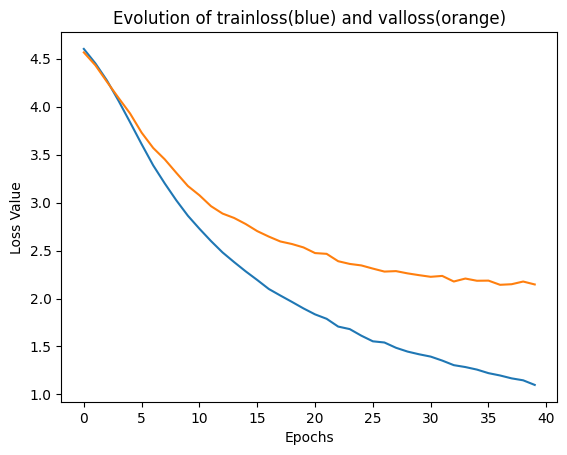

In [ ]:
plt.plot(range(len(train_L)),train_L)
plt.plot(range(len(val_L)),val_L)
plt.title('Evolution of trainloss(blue) and valloss(orange)')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')

### **See Validation results**

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    fmt = 'd'
    thresh = cm.max() / 2.

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


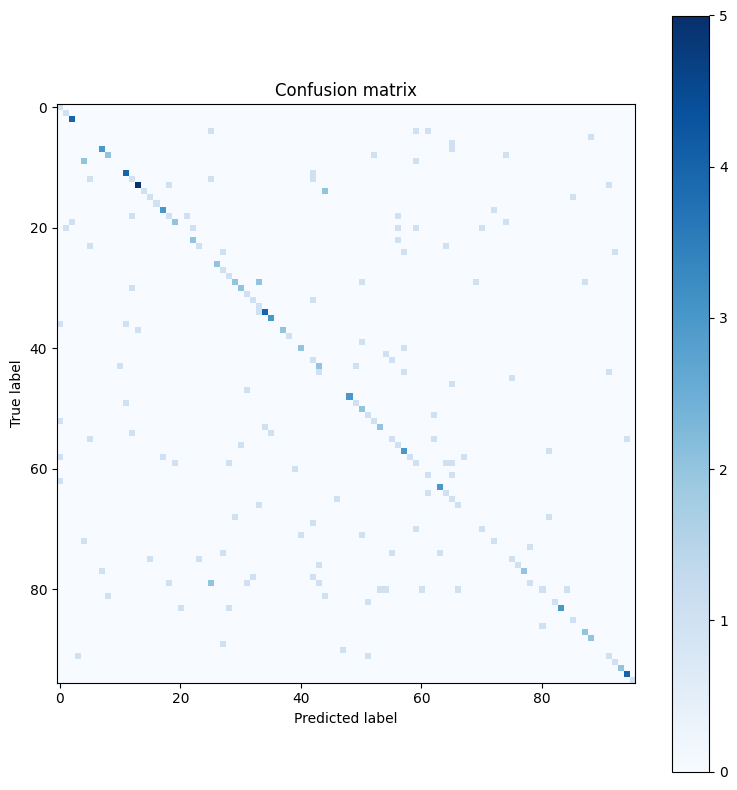

In [ ]:
classes = list(label_to_int.keys())[:num_classes]

cm = confusion_matrix(all_targets, all_preds)
plot_confusion_matrix(cm, classes, title='Confusion matrix')

This first result is pretty good. Indeed, while aiming to use painter classification to find one paintings' movement, we found out that this classification needs to be pretty accurate. The results above conforts us in keeping on trying this method.

### **Test set**

In [ ]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_targets = []
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader, desc='Validating', unit='batch')
    for inputs, targets in test_loader_tqdm:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

    test_loader_tqdm.set_postfix(test_loss=test_loss / len(test_loader.dataset), test_acc=(correct / total) * 100)

print(f'Test Loss: {test_loss/len(test_loader)}, Test Accuracy: {100.*correct/total}%')

Validating: 100%|██████████| 8/8 [00:00<00:00, 27.13batch/s]

Test Loss: 65.29515115916729, Test Accuracy: 41.92139737991266%


Here, one may found that accuracy is pretty low when in fact for this specific task and from what we see in other papers, this score is actually quite good. In general, they are not greater than 60%.

## **Use Classification to plot a TSNE-Map**

The purpose of this section is to use the features that we obtained from previous classification to find one's movement. We try to use some reducing dimension technique called TSNE to try and find a map where paintings from the same movement are grouped in the same cluster. To evaluate and visualize that, we assume that a painter is attached to one style. We found out that using birth date is crucial as one's style is influenced by the time they lived in. The thing here is that we used one's birthdate and not the date when they produced the canvas which will have its importance. Another thing here is that the TSNE projection seems to heavily rely on birthdate which is actually not the main feature we want to highlight. (we would have like our model to take advantage of textures, colors, shapes, ...)

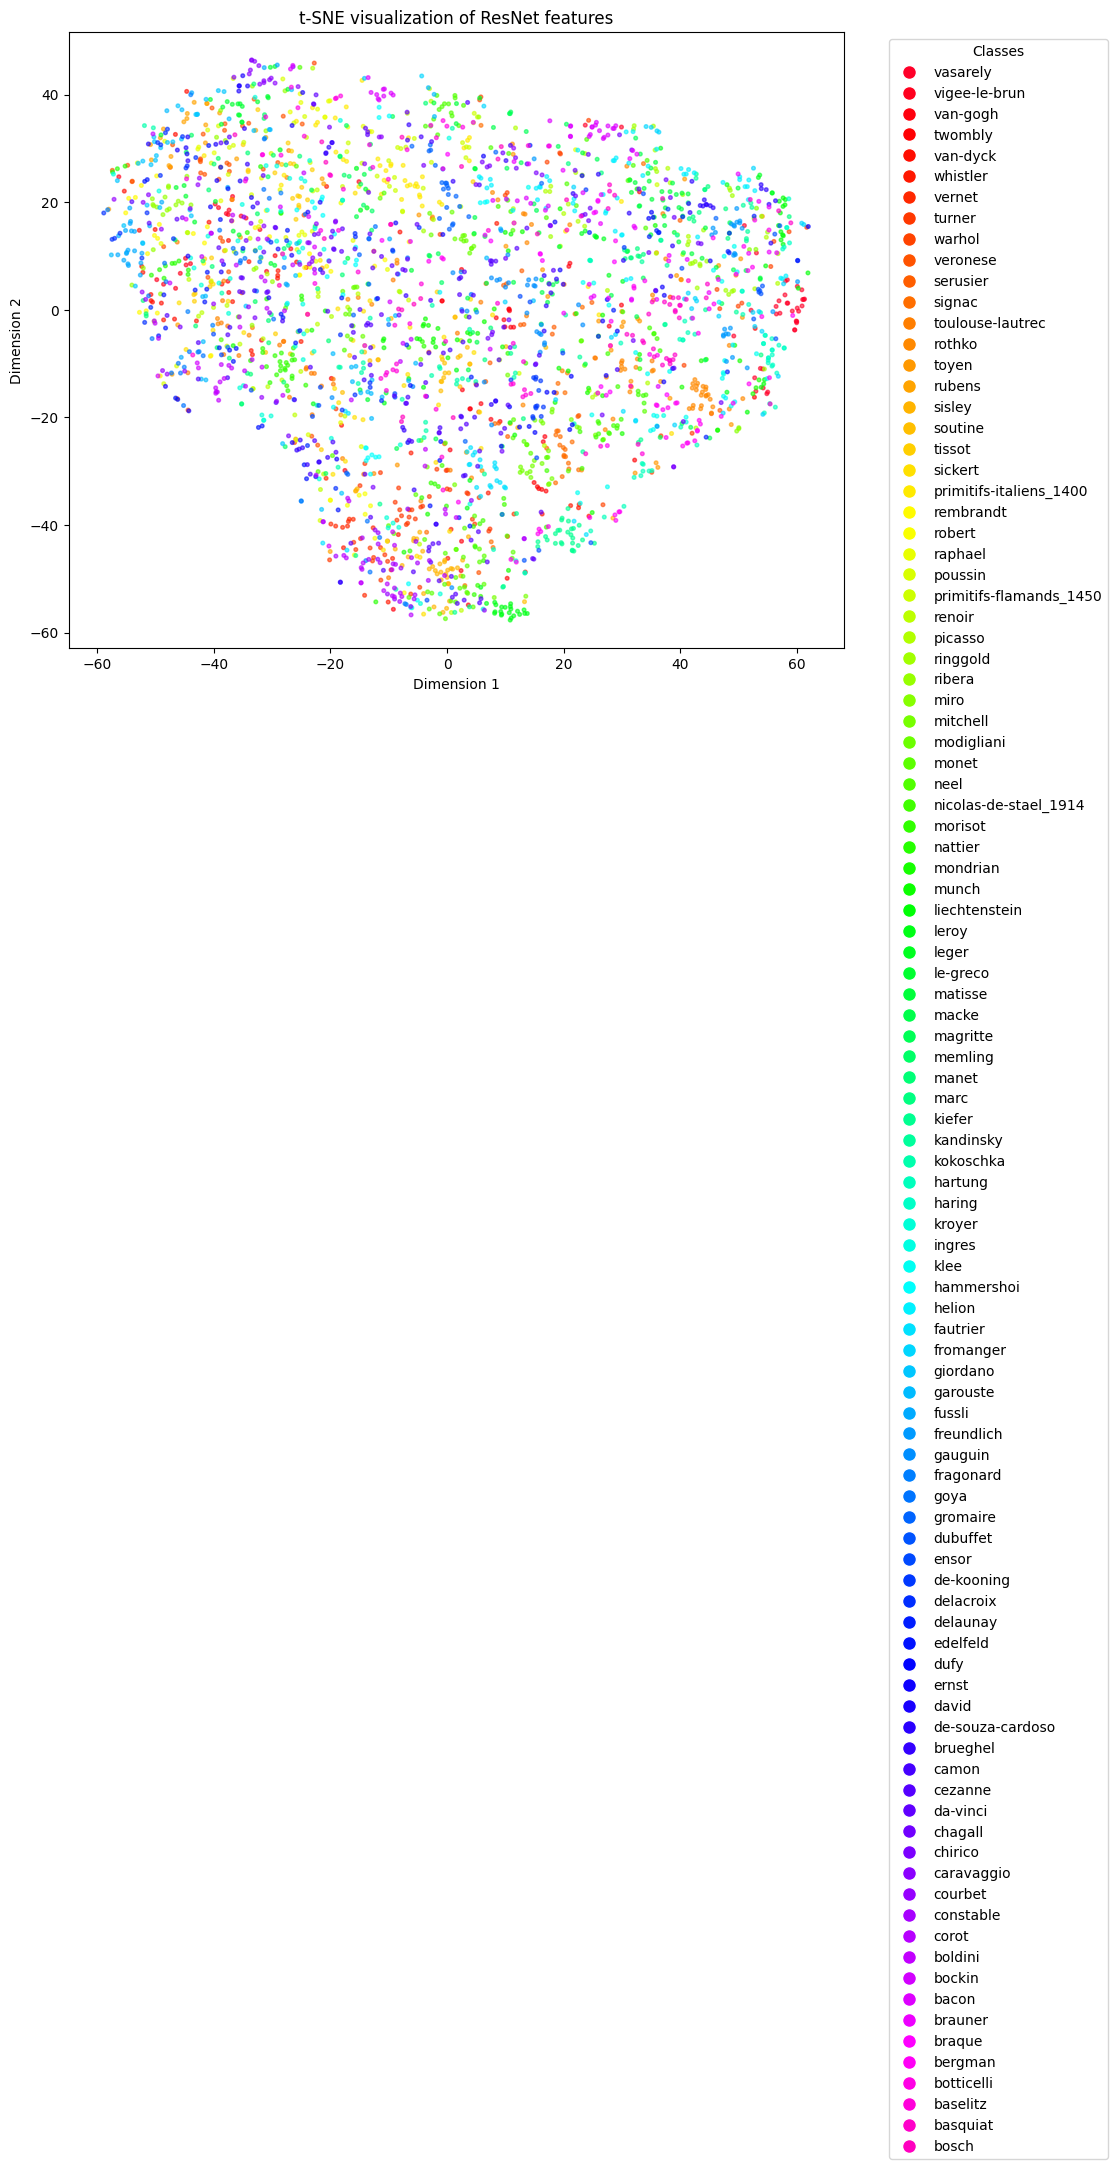

In [ ]:
features = []
labels = []
all_painter = list(df['painter'].unique())
num_classes = 100
model.eval()

dataset = TensorDataset(X_tensor, Y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        features.append(outputs)
        labels.extend(targets)

features = torch.cat(features)
features = features.cpu().numpy()
labels = torch.tensor(labels).numpy()

tsne = TSNE(n_components=2, random_state=1)
features_tsne = tsne.fit_transform(features)

colors = plt.cm.gist_rainbow(np.linspace(0, 1, num_classes)) #num_classes = 100 define above

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=all_painter[i])
                   for i in range(num_classes)]

plt.figure(figsize=(10, 8))

plt.scatter(features_tsne[:, 0], features_tsne[:, 1],s = 7, color=colors[labels], alpha=0.6)

plt.title('t-SNE visualization of ResNet features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(handles=legend_elements, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


We use those point to plot average point for each artists and find maybe in that 'averaged' map some clusters of painters belonging to the same movement.

In [ ]:
x = features_tsne[:, 0]
y = features_tsne[:, 1]

i=0
var = 0

x_moy = [0 for i in range(100)]
y_moy = [0 for i in range(100)]

for j in range(len(labels)) :
    if labels[j]==i :
        x_moy[i]+= x[j]
        y_moy[i]+= y[j]
        var+=1

    else :
        x_moy[i] = x_moy[i]/var
        y_moy[i] = y_moy[i]/var
        i+=1
        var=1
        x_moy[i]+= x[j]
        y_moy[i]+= y[j]

#cas particulier du dernier peintre
x_moy[-1] = x_moy[-1]/(var+1)
y_moy[-1] = y_moy[-1]/(var+1)

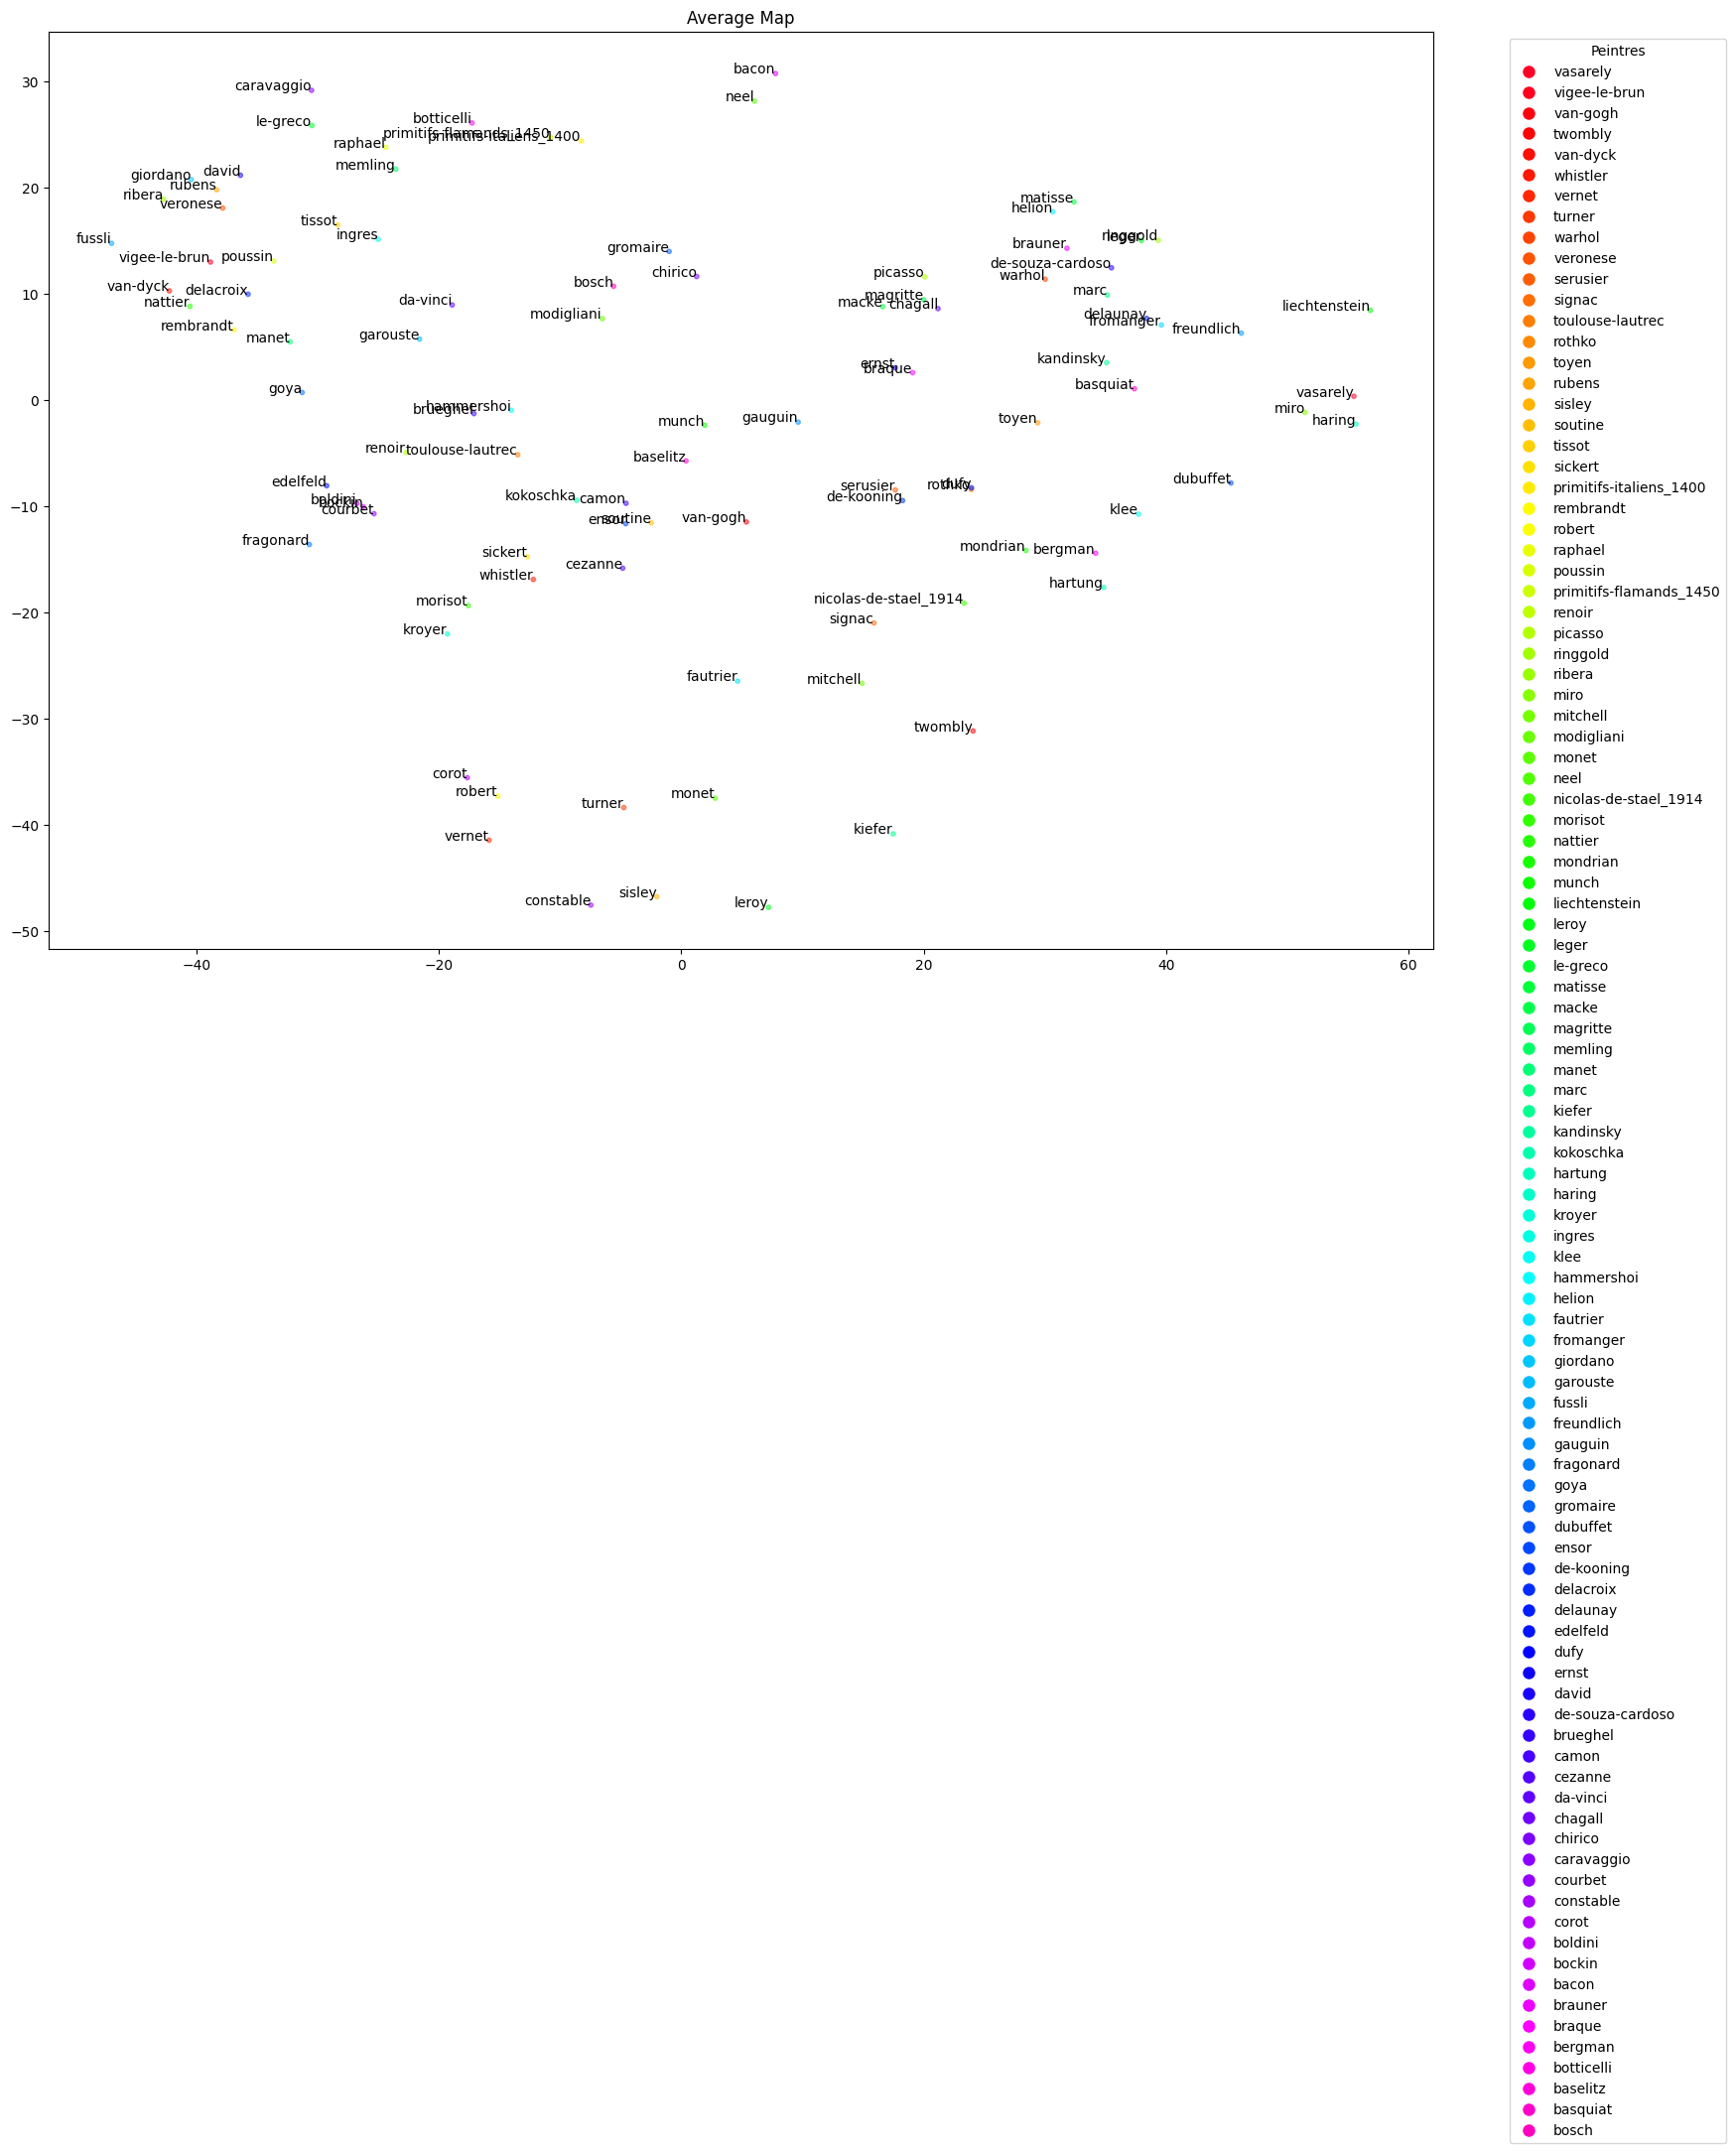

In [ ]:
colors = plt.cm.gist_rainbow(np.linspace(0, 1, num_classes))

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=all_painter[i]) for i in range(100)]

labels_bis = [i for i in range(100)]

plt.figure(figsize=(18, 12))
plt.scatter(x_moy, y_moy, s=10, alpha=0.5, color=colors[labels_bis])

for i, label in enumerate(all_painter) :
    plt.text(x_moy[i], y_moy[i], label, fontsize=10, ha='right')

plt.title('Average Map')
plt.legend(handles=legend_elements, title="Peintres", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

### **Use GMM to Cluster Artists**

In [ ]:
def plot_gaussian_ellipse(mean, cov, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Plots an ellipse representing a Gaussian with mean `mean` and covariance `cov`.
    """
    # Calculer les valeurs propres et les vecteurs propres pour la matrice de covariance
    eigvals, eigvecs = np.linalg.eigh(cov)

    # Calculer l'angle de rotation de l'ellipse
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))

    # Calculer les dimensions de l'ellipse
    width, height = 2 * n_std * np.sqrt(eigvals)

    # Créer et ajouter l'ellipse au graphique
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, facecolor=facecolor, **kwargs)
    ax.add_patch(ellipse)


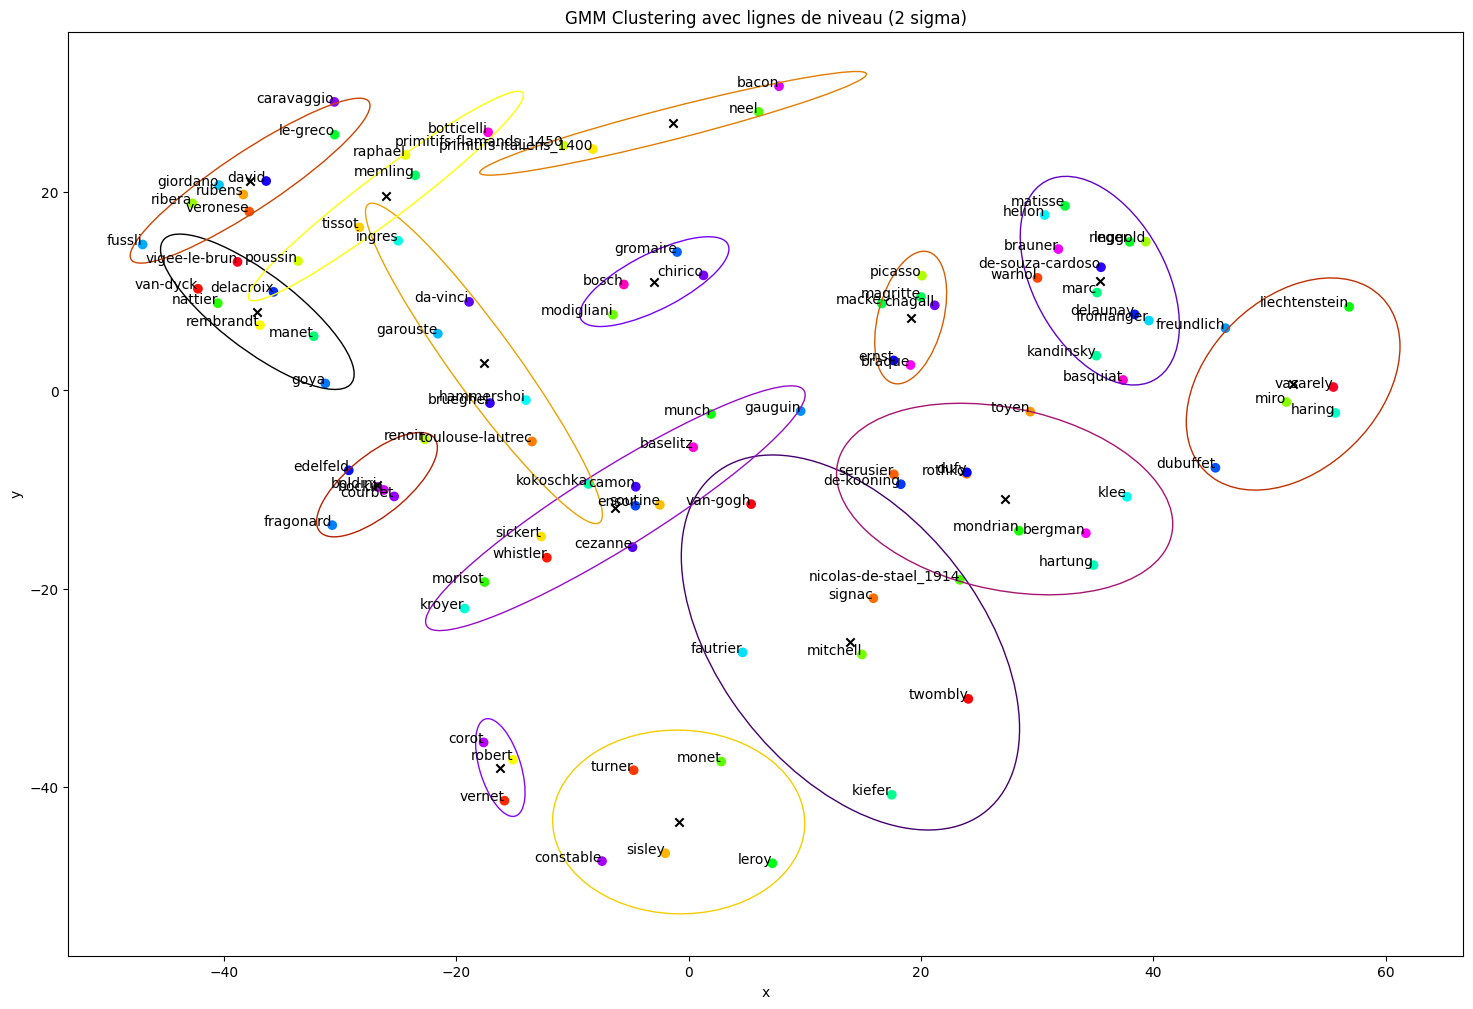

In [ ]:
n_component = 15


color_gmm = plt.cm.gnuplot(np.linspace(0, 1, n_component))

gmm = GaussianMixture(n_components=n_component, random_state=1)

X = np.array(list(zip(x_moy, y_moy)))

gmm.fit(X)
labels = gmm.predict(X)

# Recover Means and Covariances
means = gmm.means_
covariances = gmm.covariances_

# Create graph
fig, ax = plt.subplots(figsize=(18, 12))
ax.scatter(X[:, 0], X[:, 1], color=colors[labels_bis], marker='o')
ax.scatter(means[:, 0], means[:, 1], c='black', marker='x')

for i, label in enumerate(all_painter) :
    plt.text(x_moy[i], y_moy[i], label, fontsize=10, ha='right')

# Plot Ellipsis
i=0
for mean, cov in zip(means, covariances):
    plot_gaussian_ellipse(mean, cov, ax, n_std=2, edgecolor=color_gmm[i])
    i+=1


ax.set_title('GMM Clustering avec lignes de niveau (2 sigma)')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Afficher le graphique
plt.show()

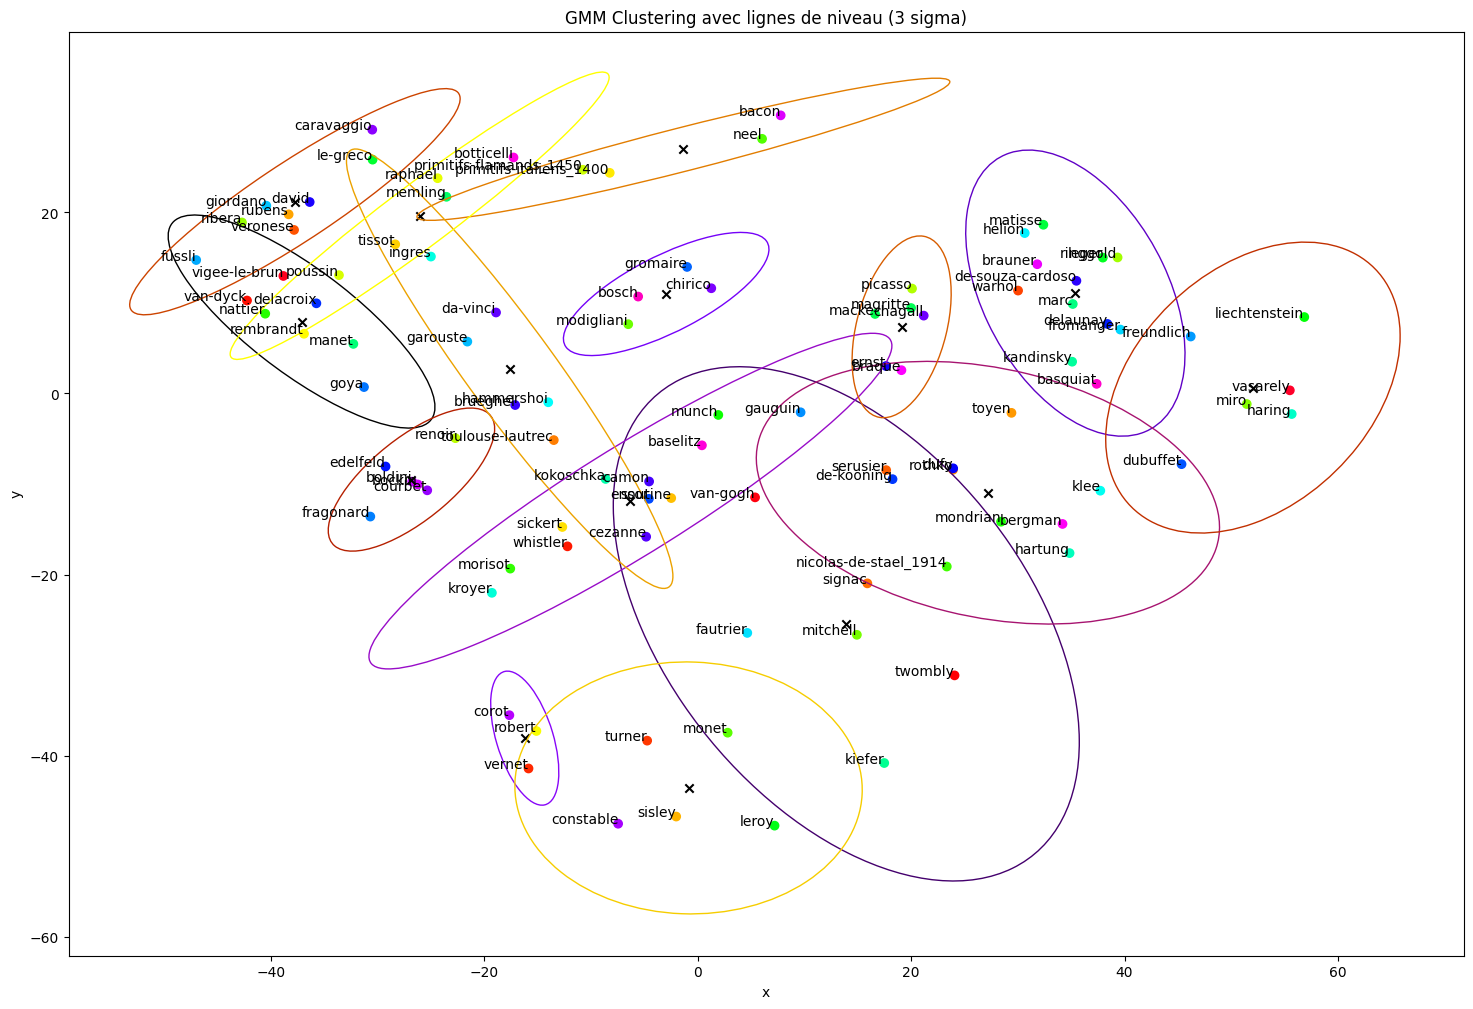

In [ ]:
n_component = 15

gmm = GaussianMixture(n_components=n_component, random_state=1)

X = np.array(list(zip(x_moy, y_moy)))

gmm.fit(X)
labels = gmm.predict(X)

# Recover Means and Covariances
means = gmm.means_
covariances = gmm.covariances_

# Create graph
fig, ax = plt.subplots(figsize=(18, 12))
ax.scatter(X[:, 0], X[:, 1], color=colors[labels_bis], marker='o')
ax.scatter(means[:, 0], means[:, 1], c='black', marker='x')  # Centroids

for i, label in enumerate(all_painter) :
    plt.text(x_moy[i], y_moy[i], label, fontsize=10, ha='right')

# Build Ellipsis
i=0
for mean, cov in zip(means, covariances):
    plot_gaussian_ellipse(mean, cov, ax, n_std=3, edgecolor=color_gmm[i])
    i+=1


ax.set_title('GMM Clustering avec lignes de niveau (3 sigma)')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Afficher le graphique
plt.show()

### **Trying to create a new map adding birthdate as feature**

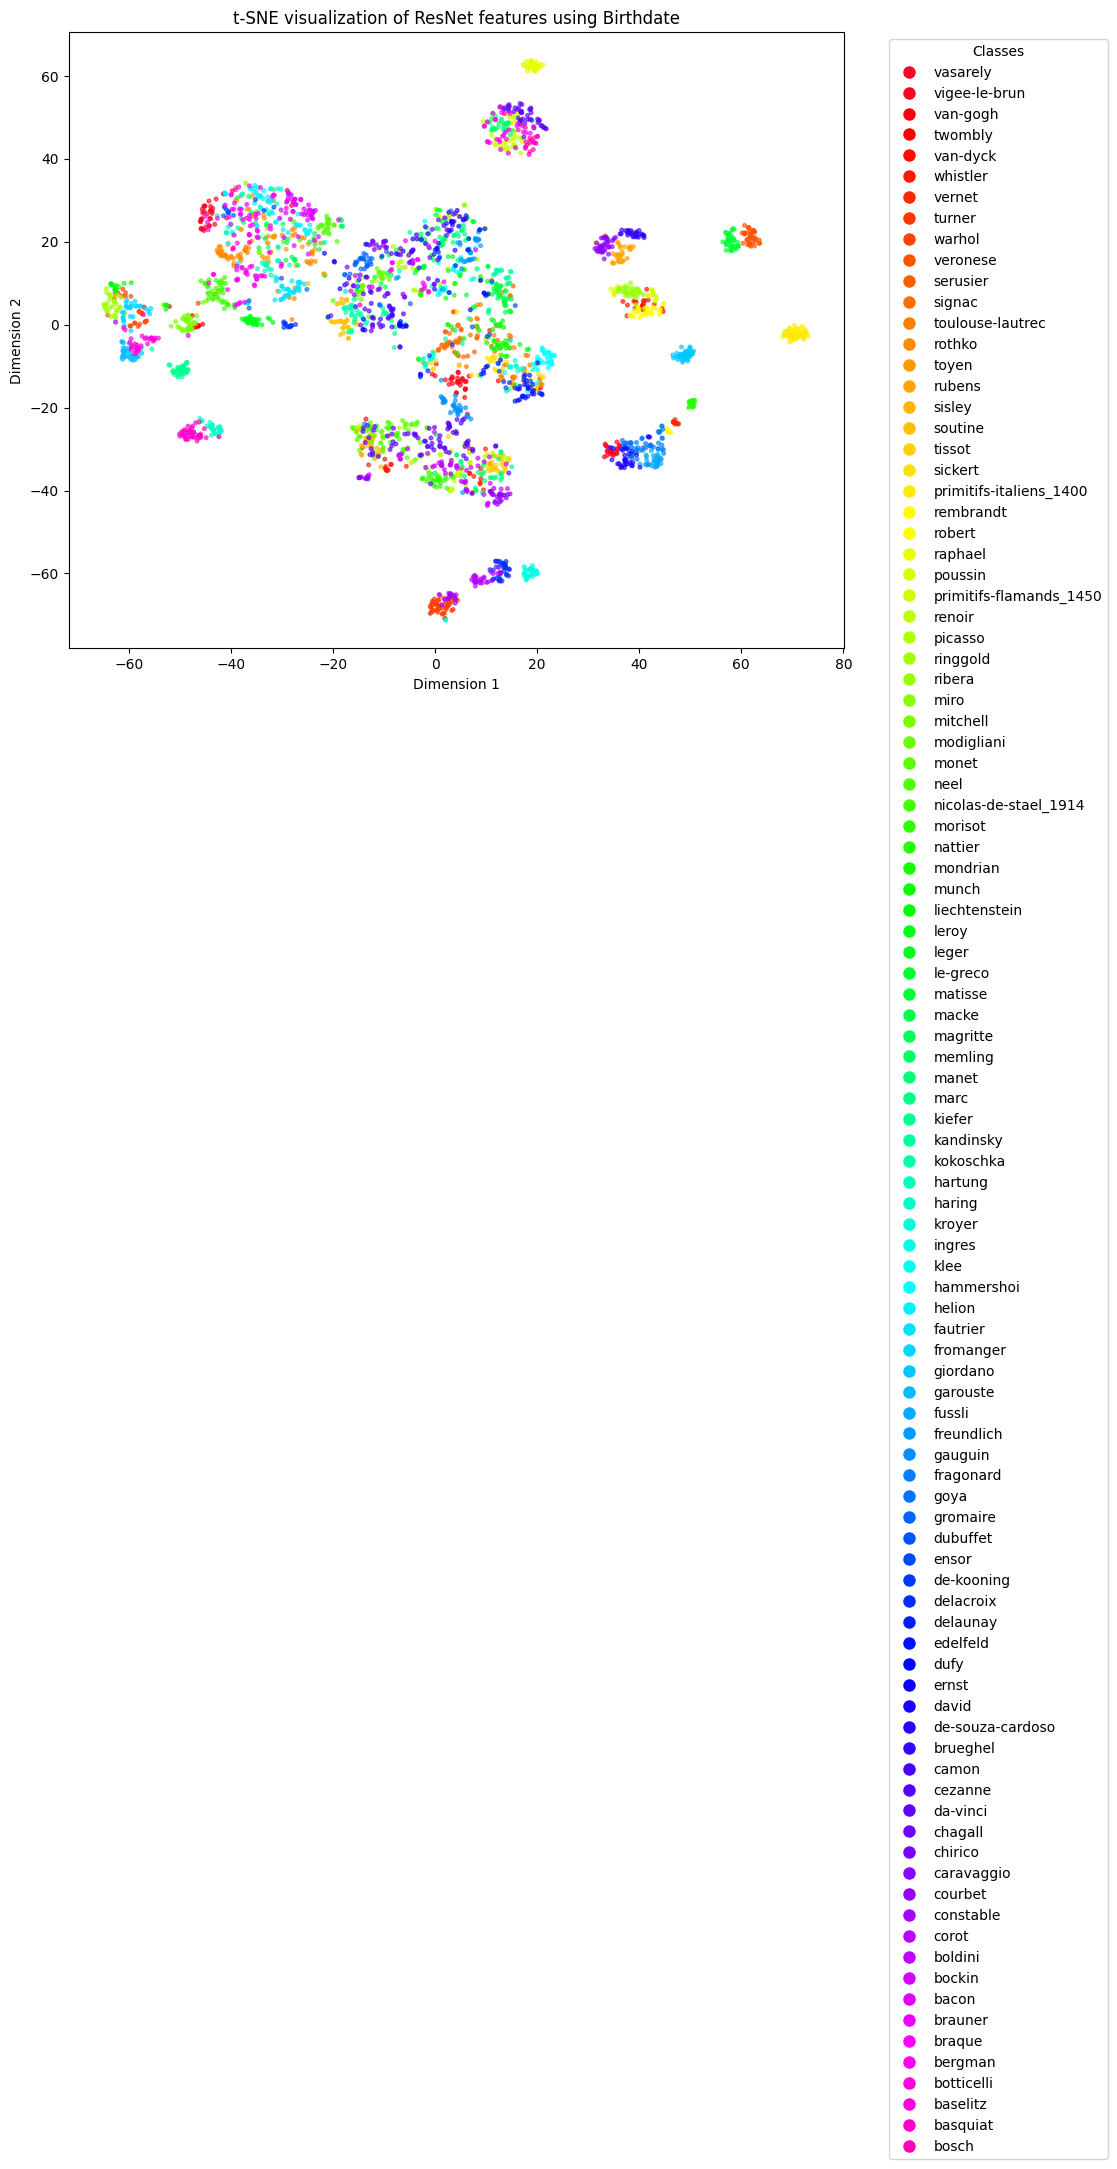

In [ ]:
features_birthdate = []
labels = []
model.eval()


dataset = TensorDataset(X_tensor, Y_tensor)


loader = DataLoader(dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        features_birthdate.append(outputs)
        labels.extend(targets)

features_birthdate = torch.cat(features_birthdate)
features_birthdate = features_birthdate.cpu().numpy()

labels = torch.tensor(labels).numpy()


features_birth = np.zeros((3060, 101))

for i in range(3060) :
    annee = df['date'][i]

    for j in range(100) :
        features_birth[i,j] = features_birthdate[i,j]
    features_birth[i,-1] = annee


tsne_b = TSNE(n_components=2, random_state=1)
features_tsne_b = tsne_b.fit_transform(features_birth)

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=all_painter[i])
                   for i in range(num_classes)]

plt.figure(figsize=(10, 8))

plt.scatter(features_tsne_b[:, 0], features_tsne_b[:, 1],s = 7, color=colors[labels], alpha=0.6)

plt.title('t-SNE visualization of ResNet features using Birthdate')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(handles=legend_elements, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [ ]:
x = features_tsne_b[:, 0]
y = features_tsne_b[:, 1]

i=0
var = 0
x_moy = [0 for i in range(100)]
y_moy = [0 for i in range(100)]

for j in range(len(labels)) :
    if labels[j]==i :
        x_moy[i]+= x[j]
        y_moy[i]+= y[j]
        var+=1

    else :
        x_moy[i] = x_moy[i]/var
        y_moy[i] = y_moy[i]/var
        i+=1
        var=1
        x_moy[i]+= x[j]
        y_moy[i]+= y[j]

#cas particulier du dernier peintre
x_moy[-1] = x_moy[-1]/(var+1)
y_moy[-1] = y_moy[-1]/(var+1)

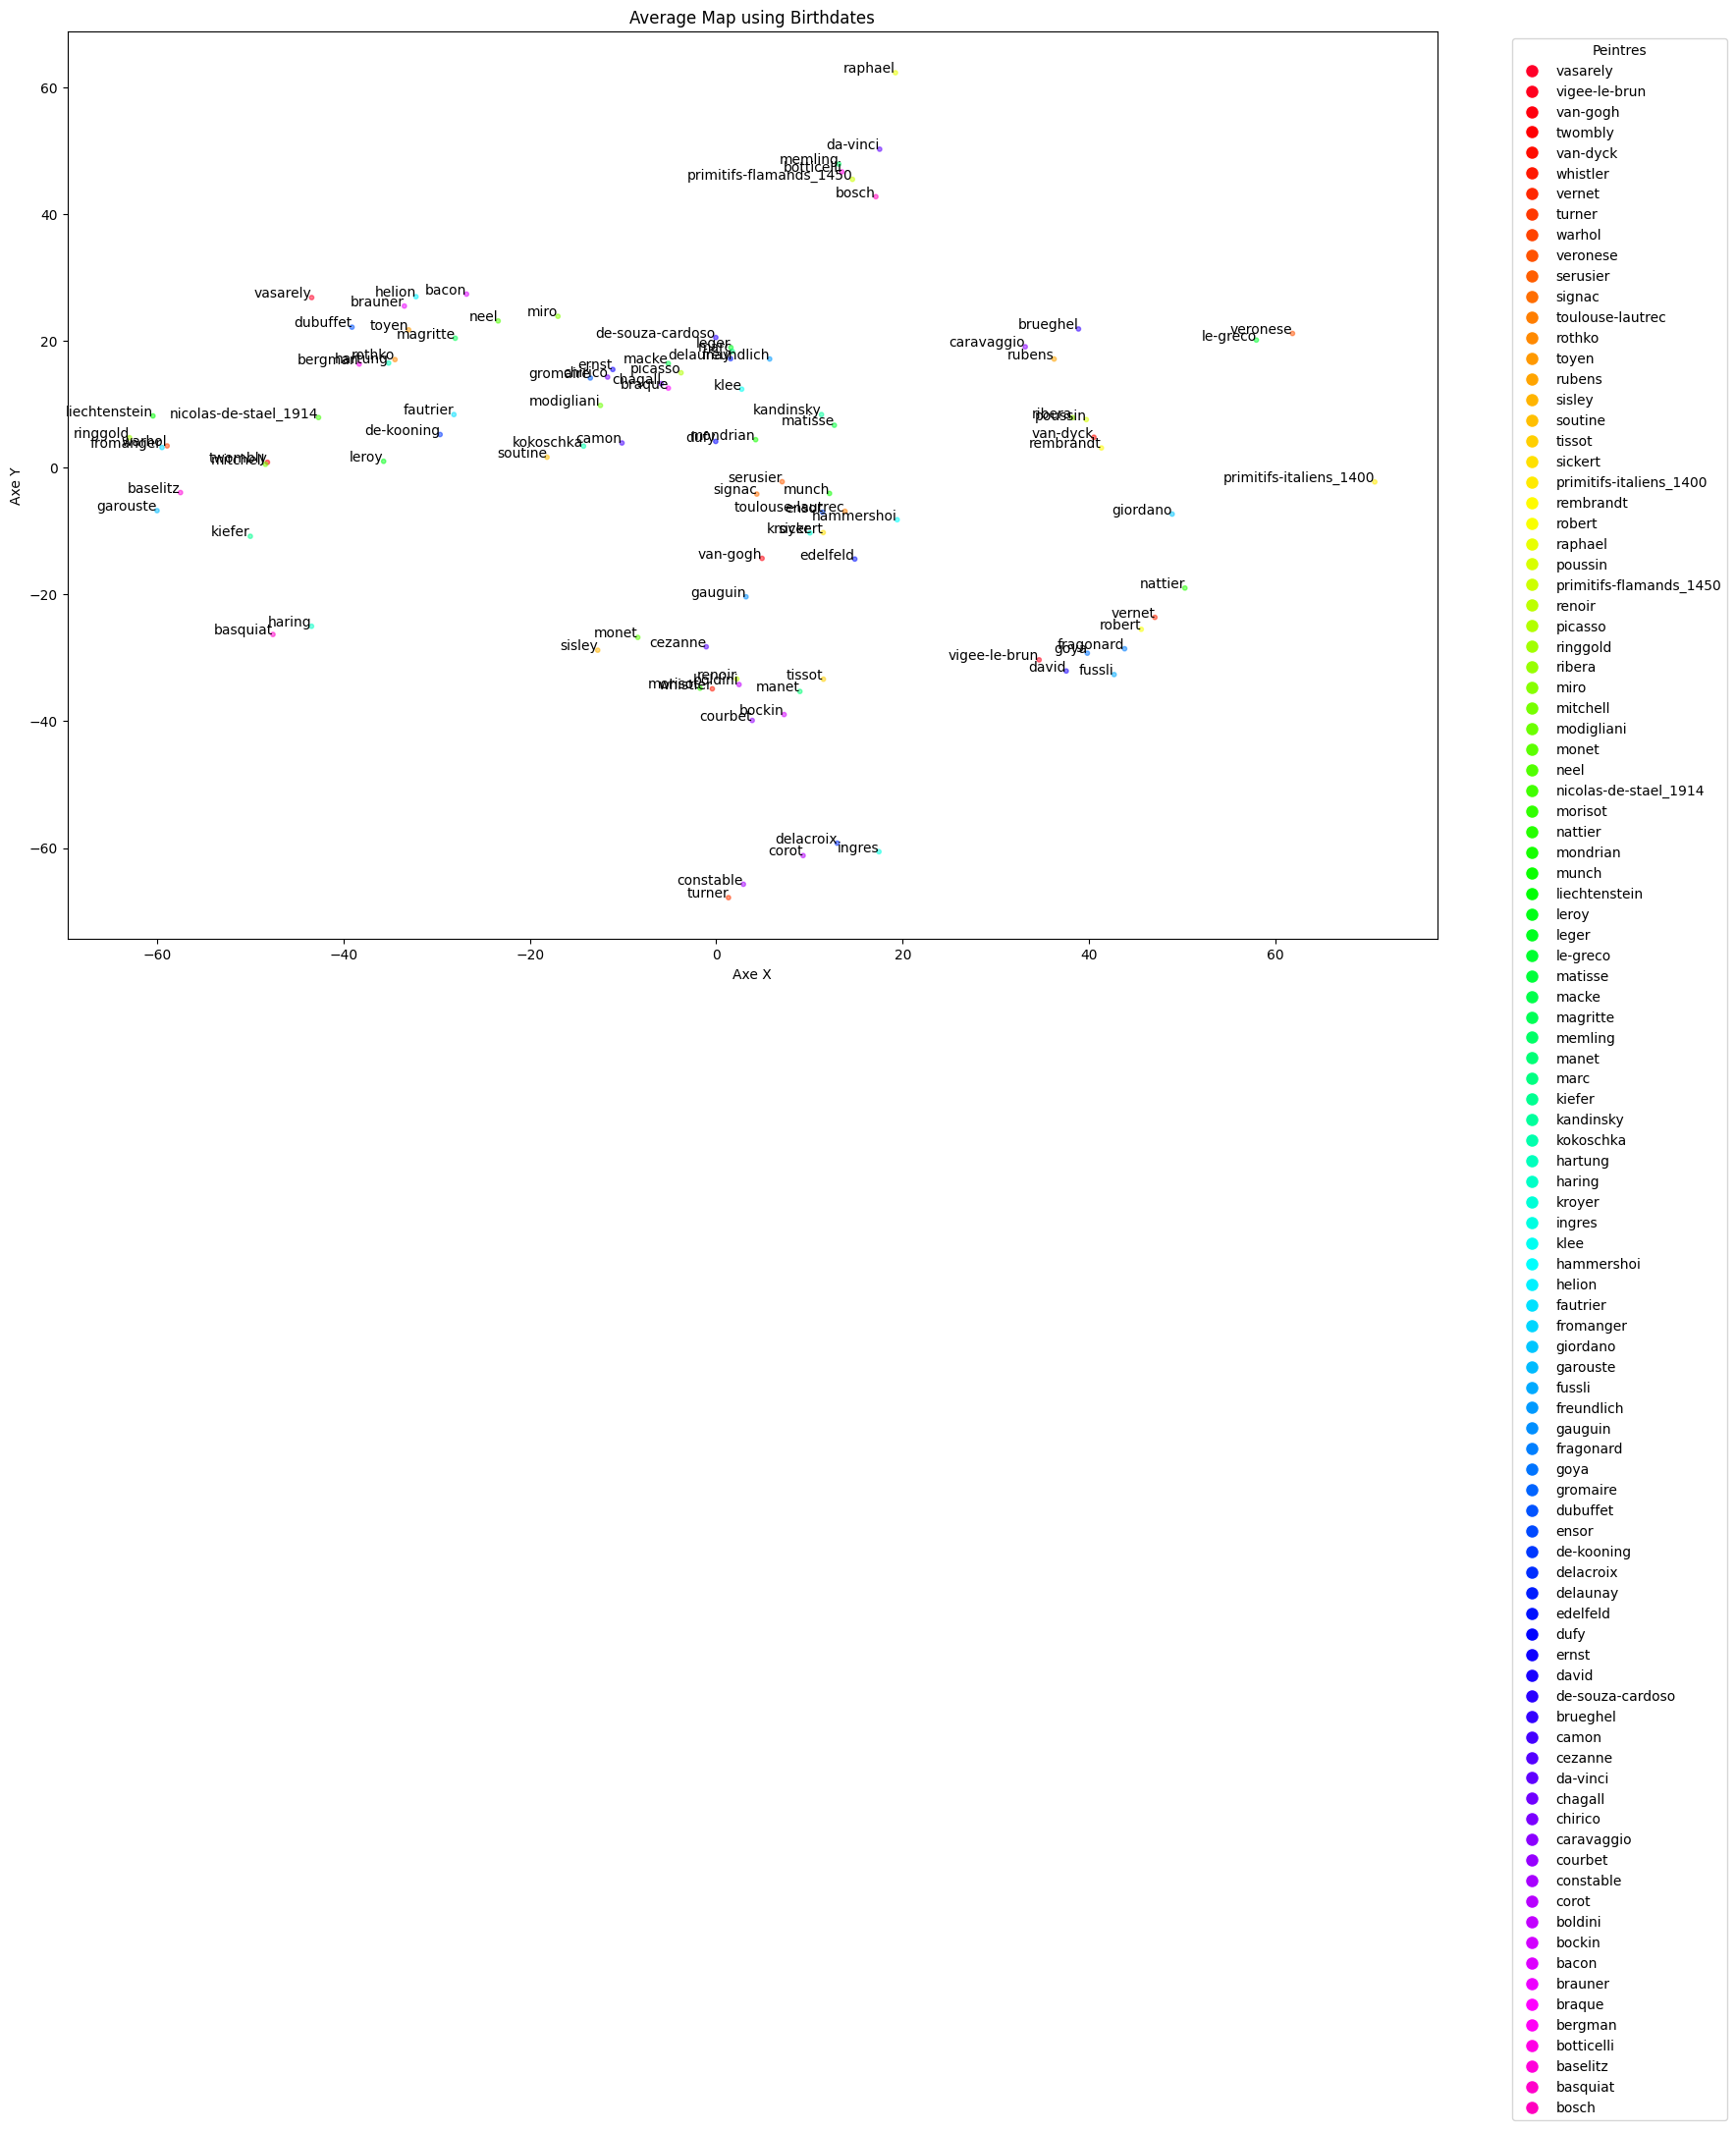

In [ ]:
colors = plt.cm.gist_rainbow(np.linspace(0, 1, 100))
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=all_painter[i]) for i in range(100)]


labels_bis = [i for i in range(100)]
plt.figure(figsize=(18, 12))
plt.scatter(x_moy, y_moy, s=10, alpha=0.5, color=colors[labels_bis])

for i, label in enumerate(all_painter) :
    plt.text(x_moy[i], y_moy[i], label, fontsize=10, ha='right')


plt.title('Average Map using Birthdates')
plt.xlabel('Axe X')
plt.ylabel('Axe Y')
plt.legend(handles=legend_elements, title="Peintres", bbox_to_anchor=(1.05, 1), loc='upper left')


plt.show()

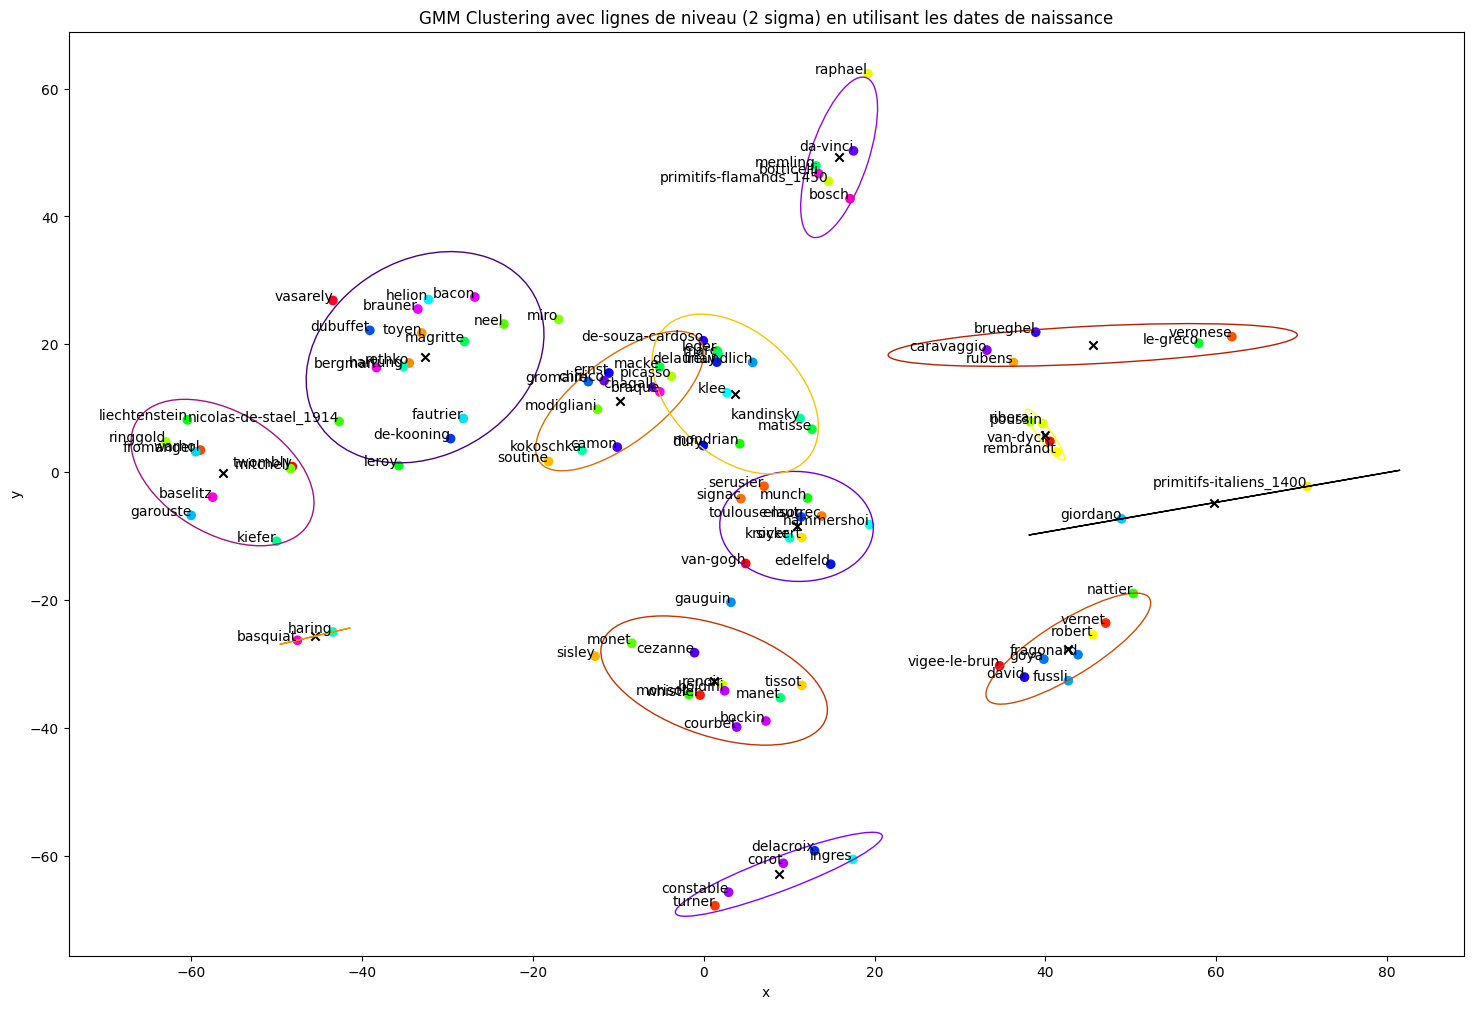

In [ ]:
n_component = 13


color_gmm = plt.cm.gnuplot(np.linspace(0, 1, n_component))

gmm = GaussianMixture(n_components=n_component, random_state=1)

X = np.array(list(zip(x_moy, y_moy)))
gmm.fit(X)
labels = gmm.predict(X)

means = gmm.means_
covariances = gmm.covariances_

fig, ax = plt.subplots(figsize=(18, 12))
ax.scatter(X[:, 0], X[:, 1], color=colors[labels_bis], marker='o')
ax.scatter(means[:, 0], means[:, 1], c='black', marker='x')  # Centroids

for i, label in enumerate(all_painter) :
    plt.text(x_moy[i], y_moy[i], label, fontsize=10, ha='right')

i=0
for mean, cov in zip(means, covariances):
    plot_gaussian_ellipse(mean, cov, ax, n_std=2, edgecolor=color_gmm[i])
    i+=1

# Ajouter les titres et les labels
ax.set_title('GMM Clustering avec lignes de niveau (2 sigma) en utilisant les dates de naissance')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Afficher le graphique
plt.show()

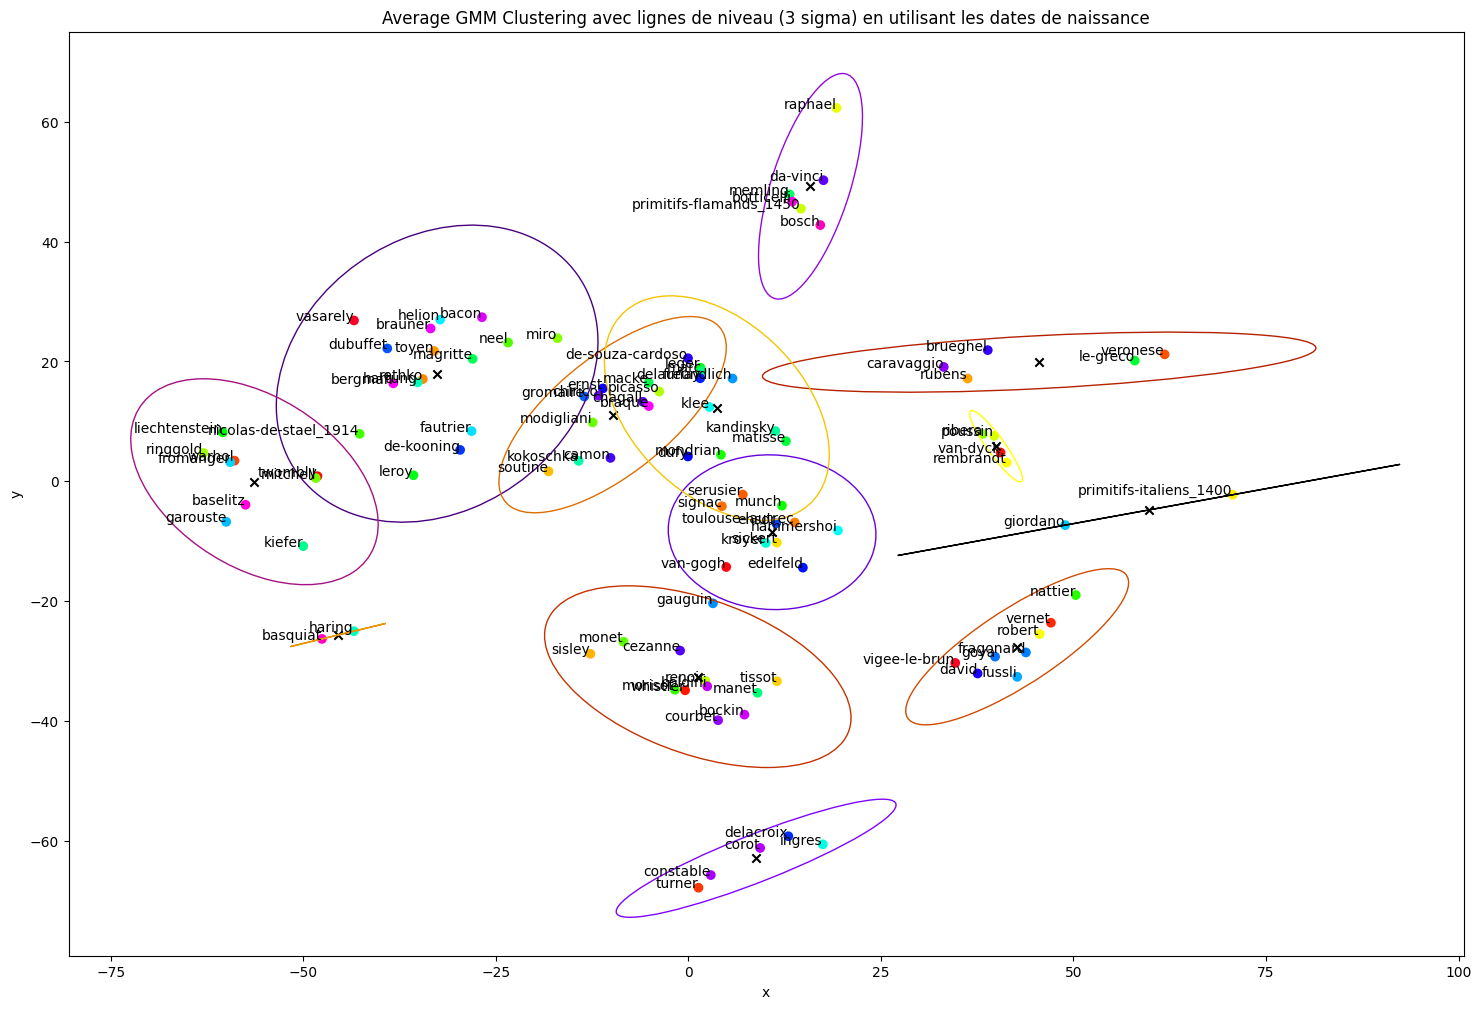

In [ ]:
n_component = 13

color_gmm = plt.cm.gnuplot(np.linspace(0, 1, n_component))

gmm = GaussianMixture(n_components=n_component, random_state=1)

X = np.array(list(zip(x_moy, y_moy)))

gmm.fit(X)
labels = gmm.predict(X)


means = gmm.means_
covariances = gmm.covariances_

fig, ax = plt.subplots(figsize=(18, 12))
ax.scatter(X[:, 0], X[:, 1], color=colors[labels_bis], marker='o')
ax.scatter(means[:, 0], means[:, 1], c='black', marker='x')

for i, label in enumerate(all_painter) :
    plt.text(x_moy[i], y_moy[i], label, fontsize=10, ha='right')

i=0
for mean, cov in zip(means, covariances):
    plot_gaussian_ellipse(mean, cov, ax, n_std=3, edgecolor=color_gmm[i])
    i+=1

ax.set_title('Average GMM Clustering avec lignes de niveau (3 sigma) en utilisant les dates de naissance')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

# Grouping artist by movement

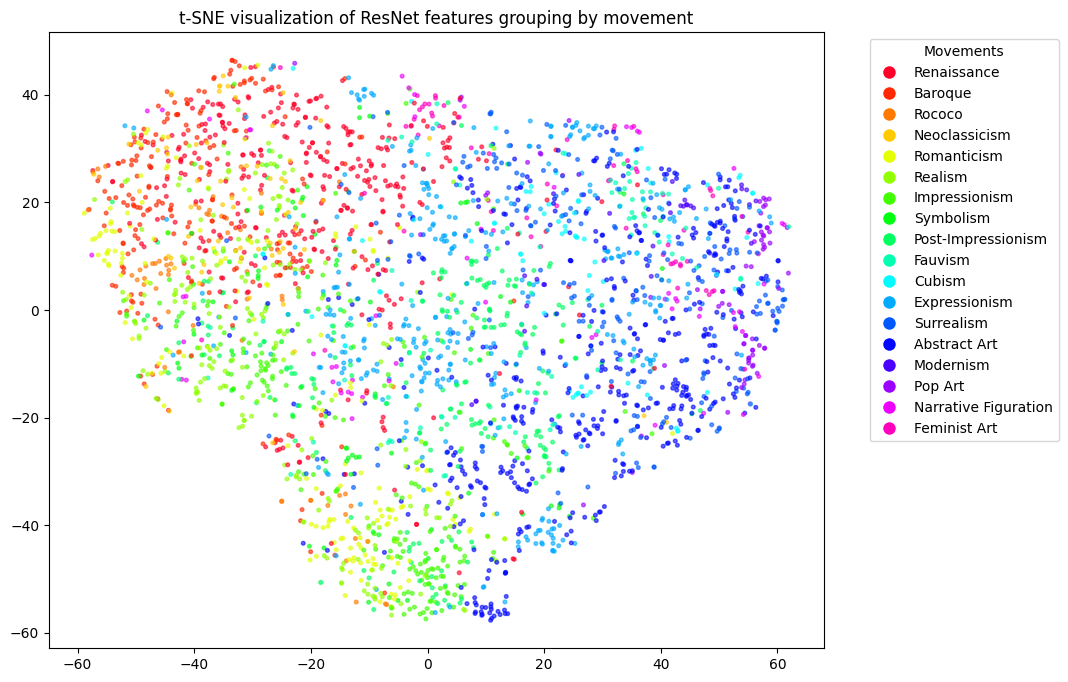

In [ ]:
painter_movements = {
    'vasarely': 'Surrealism', 'vigee-le-brun': 'Rococo', 'van-gogh': 'Post-Impressionism', 'twombly': 'Abstract Art',
    'van-dyck': 'Baroque', 'whistler': 'Symbolism', 'vernet': 'Romanticism', 'turner': 'Romanticism', 'warhol': 'Pop Art',
    'veronese': 'Renaissance', 'serusier': 'Post-Impressionism', 'signac': 'Post-Impressionism', 'toulouse-lautrec': 'Post-Impressionism',
    'rothko': 'Abstract Art', 'toyen': 'Surrealism', 'rubens': 'Baroque', 'sisley': 'Impressionism',
    'soutine': 'Expressionism', 'tissot': 'Realism', 'sickert': 'Impressionism', 'primitifs-italiens_1400': 'Renaissance',
    'rembrandt': 'Baroque', 'robert': 'Rococo', 'raphael': 'Renaissance', 'poussin': 'Baroque',
    'primitifs-flamands_1450': 'Renaissance', 'renoir': 'Impressionism', 'picasso': 'Cubism', 'ringgold': 'Feminist Art',
    'ribera': 'Baroque', 'miro': 'Surrealism', 'mitchell': 'Abstract Art', 'modigliani': 'Expressionism', 'monet': 'Impressionism',
    'neel': 'Feminist Art', 'nicolas-de-stael_1914': 'Abstract Art', 'morisot': 'Impressionism', 'nattier': 'Rococo',
    'mondrian': 'Abstract Art', 'munch': 'Expressionism', 'liechtenstein': 'Pop Art', 'leroy': 'Abstract Art', 'leger': 'Cubism',
    'le-greco': 'Renaissance', 'matisse': 'Fauvism', 'macke': 'Expressionism', 'magritte': 'Surrealism', 'memling': 'Renaissance',
    'manet': 'Impressionism', 'marc': 'Expressionism', 'kiefer': 'Expressionism', 'kandinsky': 'Abstract Art',
    'kokoschka': 'Expressionism', 'hartung': 'Abstract Art', 'haring': 'Pop Art', 'kroyer': 'Realism', 'ingres': 'Neoclassicism',
    'klee': 'Surrealism', 'hammershoi': 'Symbolism', 'helion': 'Abstract Art', 'fautrier': 'Abstract Art', 'fromanger': 'Narrative Figuration',
    'giordano': 'Baroque', 'garouste': 'Narrative Figuration', 'fussli': 'Romanticism', 'freundlich': 'Abstract Art', 'gauguin': 'Post-Impressionism',
    'fragonard': 'Rococo', 'goya': 'Romanticism', 'gromaire': 'Expressionism', 'dubuffet': 'Abstract Art', 'ensor': 'Symbolism',
    'de-kooning': 'Abstract Art', 'delacroix': 'Romanticism', 'delaunay': 'Abstract Art', 'edelfeld': 'Realism',
    'dufy': 'Fauvism', 'ernst': 'Surrealism', 'david': 'Neoclassicism', 'de-souza-cardoso': 'Modernism', 'brueghel': 'Renaissance',
    'camon': 'Fauvism', 'cezanne': 'Post-Impressionism', 'da-vinci': 'Renaissance', 'chagall': 'Surrealism',
    'chirico': 'Surrealism', 'caravaggio': 'Baroque', 'courbet': 'Realism', 'constable': 'Romanticism',
    'corot': 'Realism', 'boldini': 'Realism', 'bockin': 'Symbolism', 'bacon': 'Expressionism', 'brauner': 'Surrealism',
    'braque': 'Cubism', 'bergman': 'Abstract Art', 'botticelli': 'Renaissance', 'baselitz': 'Expressionism',
    'basquiat': 'Expressionism', 'bosch': 'Renaissance'
}

all_movements = [
 'Renaissance',
 'Baroque',
 'Rococo',
 'Neoclassicism',
 'Romanticism',
 'Realism',
 'Impressionism',
 'Symbolism',
 'Post-Impressionism',
 'Fauvism',
 'Cubism',
 'Expressionism',
 'Surrealism',
 'Abstract Art',
 'Modernism',
 'Pop Art',
 'Narrative Figuration',
 'Feminist Art'
]
features_movement = []
model.eval()

dataset = TensorDataset(X_tensor, Y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        features_movement.append(outputs)

features_movement = torch.cat(features_movement)
features_movement = features_movement.cpu().numpy()

num_classes = len(all_movements)

movement_to_idx = {movement: idx for idx, movement in enumerate(all_movements)}

# Painter <--> Movement
painter_to_movement_idx = {painter: movement_to_idx[painter_movements[painter]] for painter in all_painter}

# Link Labels to movement
labels = [painter_to_movement_idx[painter] for painter in df['painter']]
labels = np.array(labels)

# New TSNE-Map
tsne_m = TSNE(n_components=2, random_state=1)
features_tsne_movement = tsne_m.fit_transform(features_movement)

colors = plt.cm.gist_rainbow(np.linspace(0, 1, num_classes))

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=all_movements[i])
                   for i in range(num_classes)]

plt.figure(figsize=(10, 8))
plt.scatter(features_tsne_movement[:, 0], features_tsne_movement[:, 1], s=7, color=colors[labels], alpha=0.6)
plt.title('t-SNE visualization of ResNet features grouping by movement')
plt.legend(handles=legend_elements, title="Movements", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


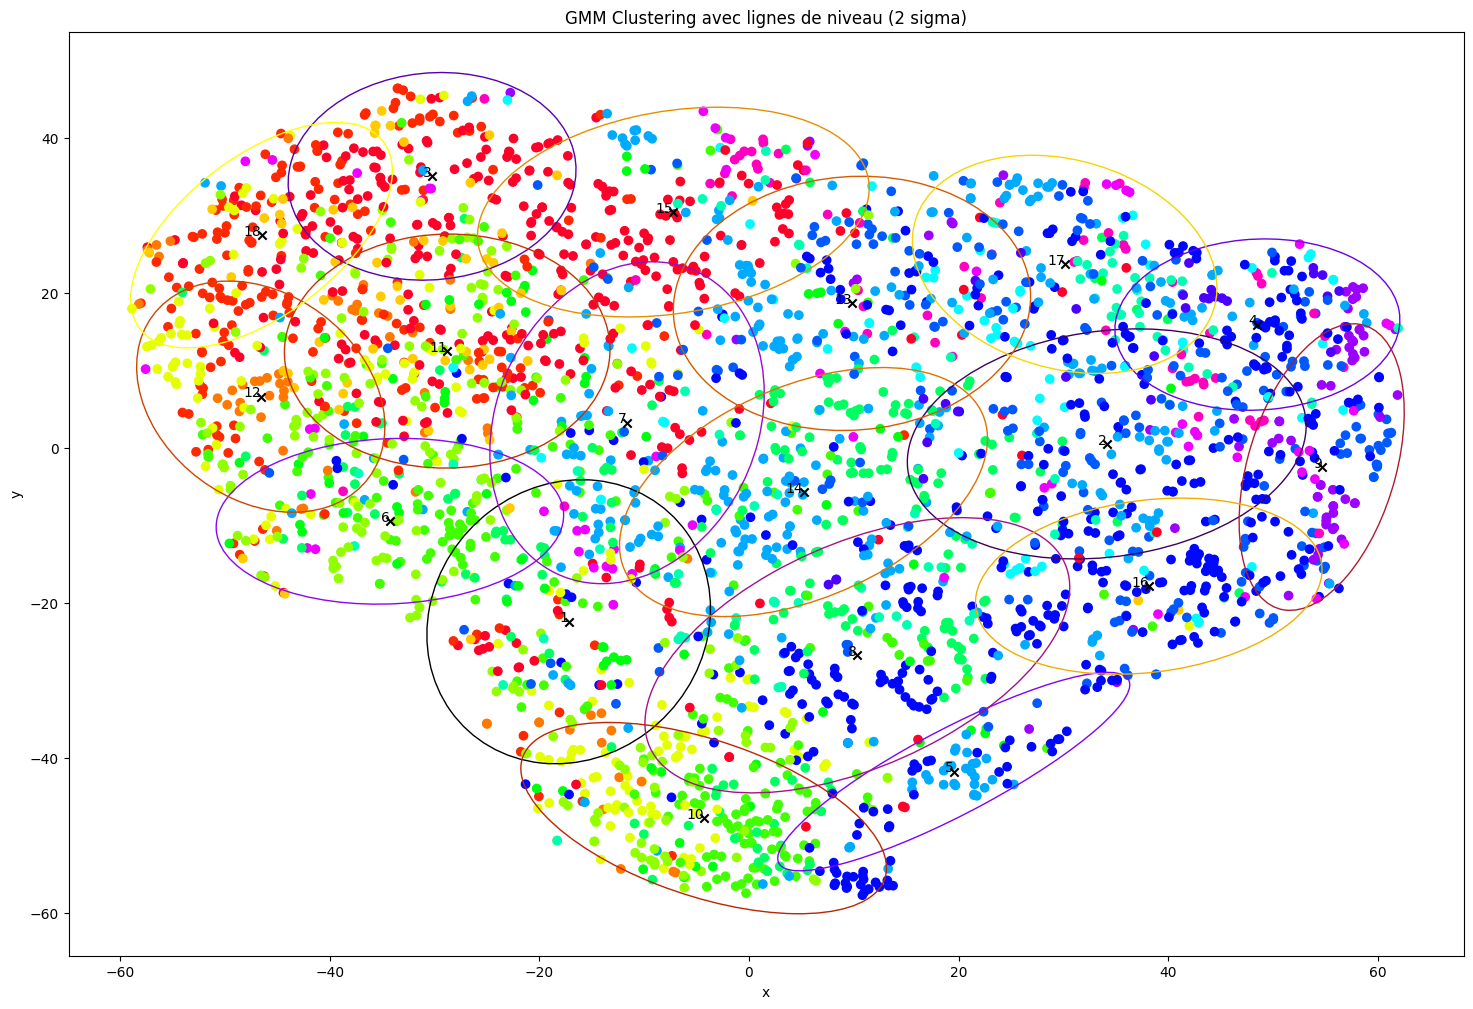

In [ ]:
n_component = num_classes

colors = plt.cm.gist_rainbow(np.linspace(0, 1, num_classes))
color_gmm = plt.cm.gnuplot(np.linspace(0, 1, n_component))


labels_bis = [painter_to_movement_idx[painter] for painter in df['painter']]
labels_bis = np.array(labels_bis)

gmm = GaussianMixture(n_components=n_component, random_state=1)

X = np.array(list(zip(features_tsne_movement[:, 0], features_tsne_movement[:, 1])))
gmm.fit(X)
labels = gmm.predict(X)

means_m = gmm.means_
covariances_m = gmm.covariances_

fig, ax = plt.subplots(figsize=(18, 12))
ax.scatter(X[:, 0], X[:, 1], color=colors[labels_bis], marker='o')
ax.scatter(means_m[:, 0], means_m[:, 1], c='black', marker='x')

i=0
for mean, cov in zip(means_m, covariances_m):
    plot_gaussian_ellipse(mean, cov, ax, n_std=2, edgecolor=color_gmm[i])
    i+=1
    ax.text(mean[0], mean[1], str(i), fontsize=10, ha='right')

ax.set_title('GMM Clustering avec lignes de niveau (2 sigma)')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

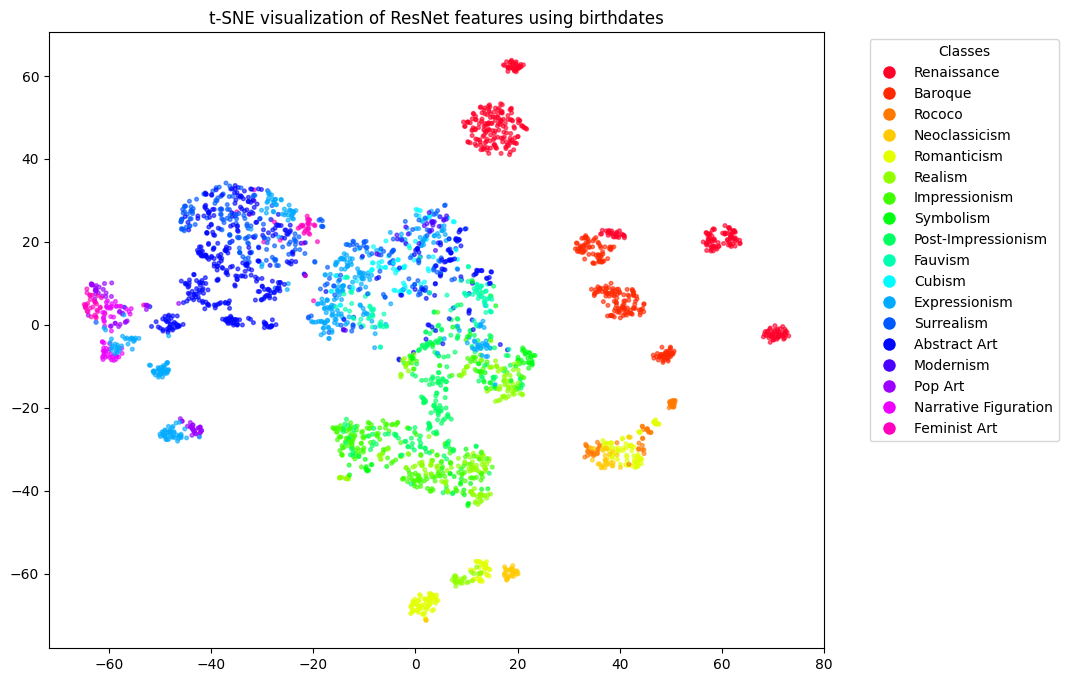

In [ ]:
features_movement_b = []
labels = []

model.eval()

dataset = TensorDataset(X_tensor, Y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        features_movement_b.append(outputs)
        labels.extend(targets)

features_movement_b = torch.cat(features_movement_b)
features_movement_b = features_movement_b.cpu().numpy()

features_movement_birth = np.zeros((3060, 101))

for i in range(3060) :
    label = labels[i]
    annee = df['date'][i]

    for j in range(100) :
        features_movement_birth[i,j] = features_movement_b[i,j]
    features_movement_birth[i,-1] = annee

labels = [painter_to_movement_idx[painter] for painter in df['painter']]
labels = np.array(labels)

tsne_mb = TSNE(n_components=2, random_state=1)
features_tsne_mb = tsne_mb.fit_transform(features_movement_birth)


colors = plt.cm.gist_rainbow(np.linspace(0, 1, num_classes))
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=all_movements[i])
                   for i in range(num_classes)]

plt.figure(figsize=(10, 8))

plt.scatter(features_tsne_mb[:, 0], features_tsne_mb[:, 1],s = 7, color=colors[labels], alpha=0.6)

plt.title('t-SNE visualization of ResNet features using birthdates')
plt.legend(handles=legend_elements, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


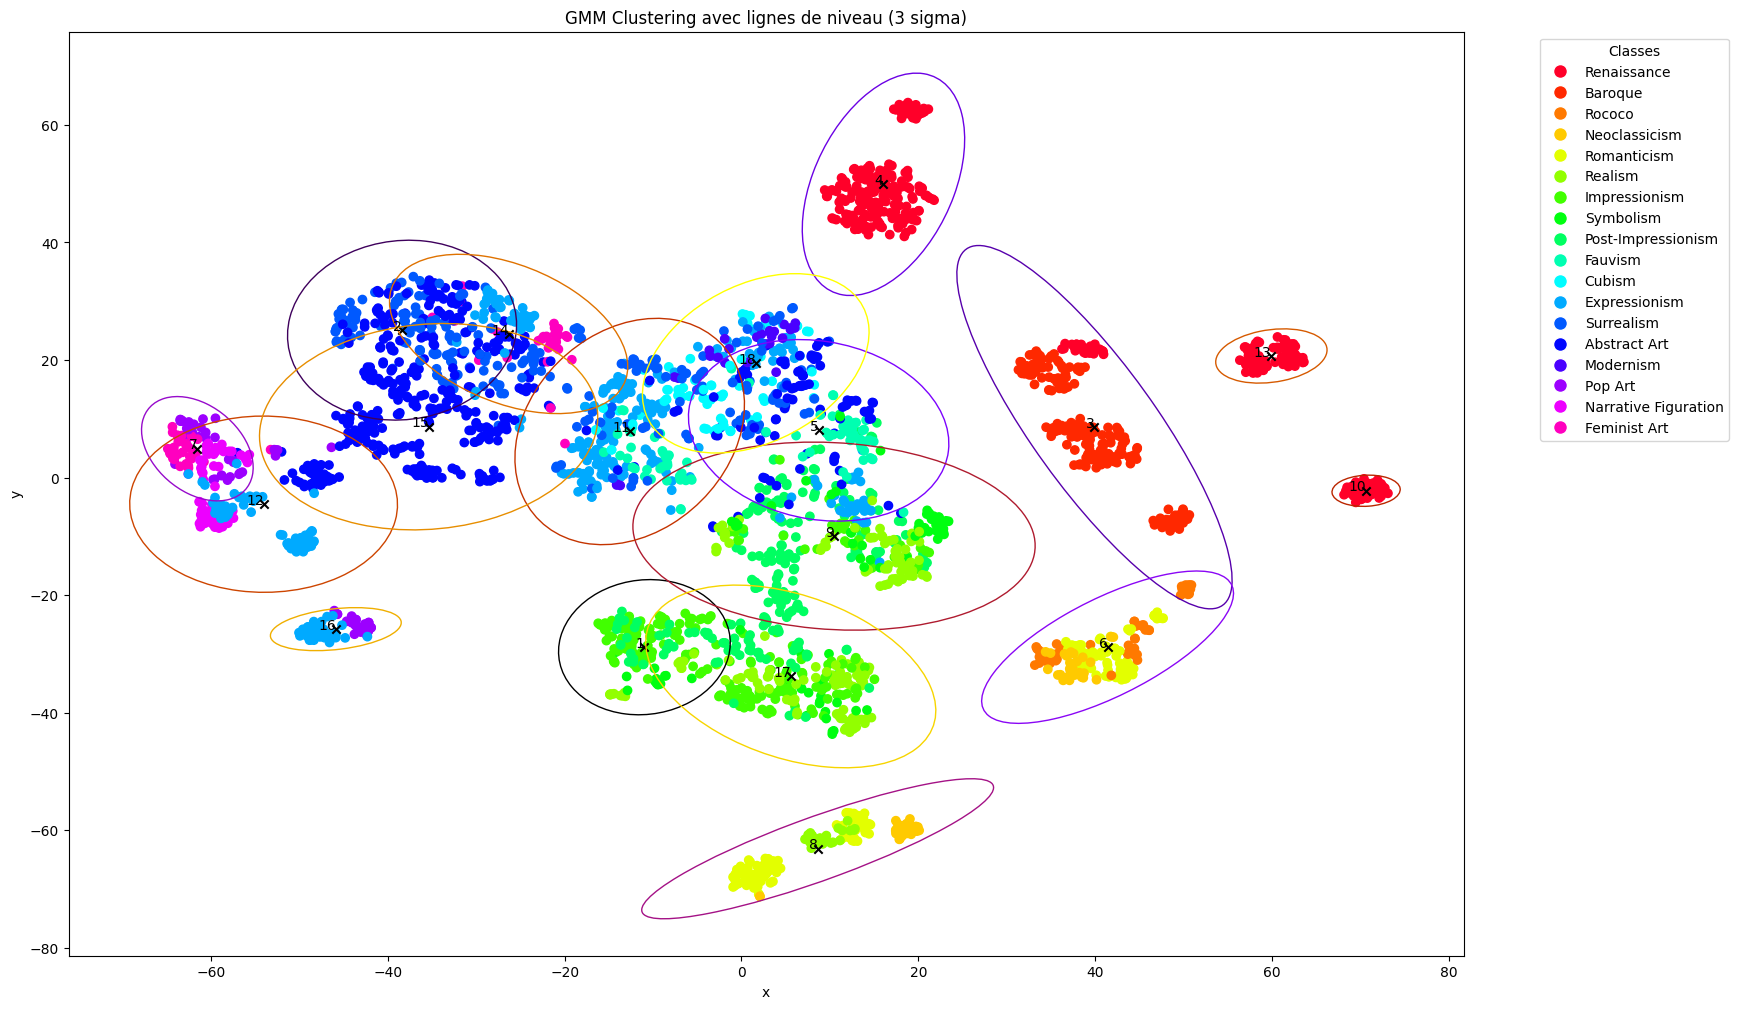

In [ ]:
n_component = num_classes

colors = plt.cm.gist_rainbow(np.linspace(0, 1, num_classes))
color_gmm = plt.cm.gnuplot(np.linspace(0, 1, n_component))

labels_bis = [painter_to_movement_idx[painter] for painter in df['painter']]
labels_bis = np.array(labels_bis)

gmm = GaussianMixture(n_components=n_component, random_state=1)

X = np.array(list(zip(features_tsne_mb[:, 0], features_tsne_mb[:, 1])))

gmm.fit(X)
labels = gmm.predict(X)

means_mb = gmm.means_
covariances_mb = gmm.covariances_

fig, ax = plt.subplots(figsize=(18, 12))
ax.scatter(X[:, 0], X[:, 1], color=colors[labels_bis], marker='o')
ax.scatter(means_mb[:, 0], means_mb[:, 1], c='black', marker='x')

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=all_movements[i])
                   for i in range(num_classes)]

i=0
for mean, cov in zip(means_mb, covariances_mb):
    plot_gaussian_ellipse(mean, cov, ax, n_std=3, edgecolor=color_gmm[i])
    i+=1
    ax.text(mean[0], mean[1], str(i), fontsize=10, ha='right')

ax.set_title('GMM Clustering avec lignes de niveau (3 sigma)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(handles=legend_elements, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')


### **Find the movement of an unknown painting**

In this section, we test our model with unseen data. As the TSNE function from sklearn does not have any '.transform' method. We try to code it from scratch( at least an equivalent ) using documentation from TSNE and computing euclidean distance.

In [ ]:
def calculate_joint_probabilities(X_new, X_train, tsne_model):
    """
    This function aims to compute joint probability between new vector of features and the model ones.
    Parameters
    ----------
    X_new : vector of features
    X_train : inputs of the model
    tsne_model : used model

    Returns
    -------
    P_joint : joint_probability
    """
    perplexity = tsne_model.perplexity
    n_samples_new = X_new.shape[0]
    n_samples_train = X_train.shape[0]

    P_joint = np.zeros((n_samples_new, n_samples_train))

    for i in range(n_samples_new):
        x_new_i = X_new[i]
        # Compute Euclidean distances
        distances = np.sum((X_train - x_new_i) ** 2, axis=1)

        # Compute conditional probabilities
        pij = np.zeros(n_samples_train)
        sum_pi = 0.0
        for j in range(n_samples_train):
            if i != j:
                pij[j] = np.exp(-distances[j] / (2 * (perplexity * tsne_model.early_exaggeration) ** 2))
                sum_pi += pij[j]

        # Normalize
        P_joint[i, :] = pij / sum_pi

    return P_joint

In [ ]:
def calculate_tsne_point(X_train, X_new, tsne_model):
    """
    This function returns the coordinates of the new canva which features are X_new in TSNE map
    ----------
    X_new : vector of features
    X_train : inputs of the model
    tsne_model : used model

    Returns
    -------
    tsne_coordinates : coordinates of X_new in TSNE MAP
    """
    P = tsne_model.kl_divergence_
    Q = tsne_model.embedding_

    P_new = calculate_joint_probabilities(X_new,X_train,tsne_model)
    distances = np.sum(P_new * np.log((P_new + 1e-15) / (P + 1e-15)), axis=0)

    tsne_coordinates = np.dot(distances, Q)

    return tsne_coordinates

In [ ]:
def mahalanobis_distance(point, mean, covariance):
    diff = point - mean
    inv_cov = np.linalg.inv(covariance)
    return np.sqrt(diff.T @ inv_cov @ diff)

def euclidean_distance(point, mean):
    return np.sqrt(np.sum((point - mean) ** 2))

We now test our pipeline on a brand new painting. We will try its influence on both the usual map and the one using the birthdate of the author.

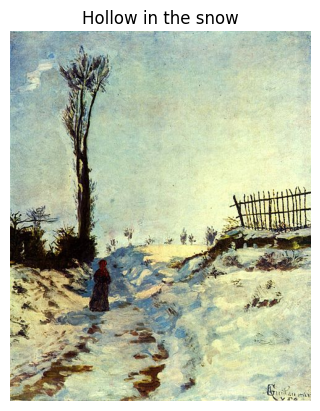


Coordonnées t-SNE du nouveau point X_new :
 [-3.57040155  6.16390761]

Coordonnées t-SNE du nouveau point X_new avec la date de naissance :
 [28.10398396 20.6101649 ]
The point is within the ellipsis : 7
The closest mean is: 7
The closest ellipsis is : 7 
The point is not within any ellipsis.
The closest mean is: 3
The closest ellipsis is : 3 


In [ ]:
path = '/content/drive/My Drive/IMA206-Projet/hollow-in-the-snow-1869.jpg'
image = Image.open(path)

plt.imshow(image)
plt.title('Hollow in the snow')
plt.axis('off')
plt.show()

img_tensor, _ = format_image(path)

features = []
labels = []
model.eval()



with torch.no_grad():
  img_tensor = img_tensor.to(device)
  outputs = model(img_tensor)
  features.append(outputs)

features = torch.cat(features)
features = features.cpu().numpy()

features_b = np.zeros((1, 101))

for j in range(100) :
  features_b[0,j] = features[0,j]
features_b[0,-1] = 1841

X_new_tsne = calculate_tsne_point(features_movement, features, tsne_m)
X_new_tsne_b = calculate_tsne_point(features_movement_birth, features_b, tsne_mb)


print("\nCoordonnées t-SNE du nouveau point X_new :\n", X_new_tsne)
print("\nCoordonnées t-SNE du nouveau point X_new avec la date de naissance :\n", X_new_tsne_b)

point_within_ellipsis = False
mahalanobis_distances = []
index = 0
for mean, covariance in zip(means_m, covariances_m):
    index+=1
    md = mahalanobis_distance(X_new_tsne, mean, covariance)
    mahalanobis_distances.append(md)
    if md <= 2:
        point_within_ellipsis = True
        print(f"The point is within the ellipsis : {index}")

if not point_within_ellipsis:
    print("The point is not within any ellipsis.")


distances = [euclidean_distance(X_new_tsne, mean) for mean in means_m]
closest_mean_index = np.argmin(distances)
closest_mean = means_m[closest_mean_index]

print(f"The closest mean is: {closest_mean_index+1}")
closest_ellipsis_index = np.argmin(mahalanobis_distances)
closest_ellipsis_mean = means_m[closest_ellipsis_index]
closest_ellipsis_covariance = covariances_m[closest_ellipsis_index]

print(f"The closest ellipsis is : {closest_ellipsis_index+1} ")

#### With birth date ####
point_within_ellipsis_b = False
mahalanobis_distances_b = []
index = 0
for mean, covariance in zip(means_mb, covariances_mb):
    index+=1
    md = mahalanobis_distance(X_new_tsne_b, mean, covariance)
    mahalanobis_distances_b.append(md)
    if md <= 2:
        point_within_ellipsis_b = True
        print(f"The point is within the ellipsis : {index}")

if not point_within_ellipsis_b:
    print("The point is not within any ellipsis.")


distances = [euclidean_distance(X_new_tsne_b, mean) for mean in means_mb]
closest_mean_index = np.argmin(distances)
closest_mean = means_mb[closest_mean_index]

print(f"The closest mean is: {closest_mean_index+1}")
closest_ellipsis_index = np.argmin(mahalanobis_distances_b)
closest_ellipsis_mean = means_mb[closest_ellipsis_index]
closest_ellipsis_covariance = covariances_mb[closest_ellipsis_index]

print(f"The closest ellipsis is : {closest_ellipsis_index+1} ")



# Modify the influence of birthdates

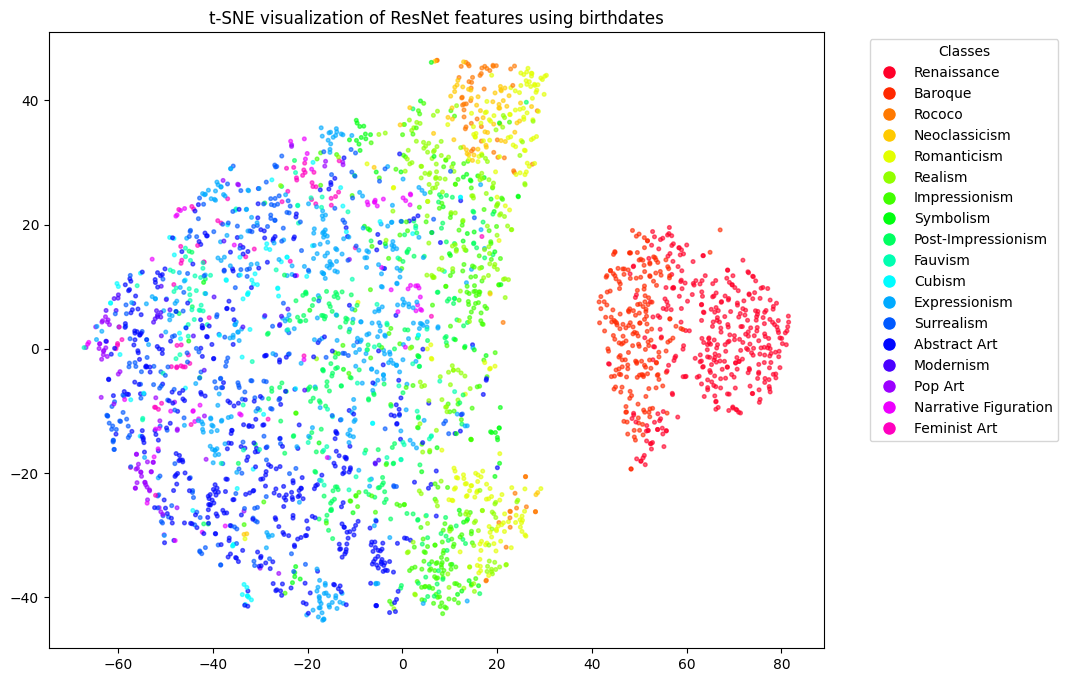

In [ ]:
features = []
labels = []

model.eval()

dataset = TensorDataset(X_tensor, Y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        features.append(outputs)
        labels.extend(targets)

features = torch.cat(features)
features = features.cpu().numpy()

features_birth = np.zeros((3060, 101))

for i in range(3060) :
    label = labels[i]
    annee = df['date'][i]

    for j in range(100) :
        features_birth[i,j] = features[i,j]
    features_birth[i,-1] = annee/10

labels = [painter_to_movement_idx[painter] for painter in df['painter']]
labels = np.array(labels)

tsne = TSNE(n_components=2, random_state=1)
features_tsne = tsne.fit_transform(features_birth)


colors = plt.cm.gist_rainbow(np.linspace(0, 1, num_classes))
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=all_movements[i])
                   for i in range(num_classes)]

plt.figure(figsize=(10, 8))

plt.scatter(features_tsne[:, 0], features_tsne[:, 1],s = 7, color=colors[labels], alpha=0.6)

plt.title('t-SNE visualization of ResNet features using birthdates')
plt.legend(handles=legend_elements, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


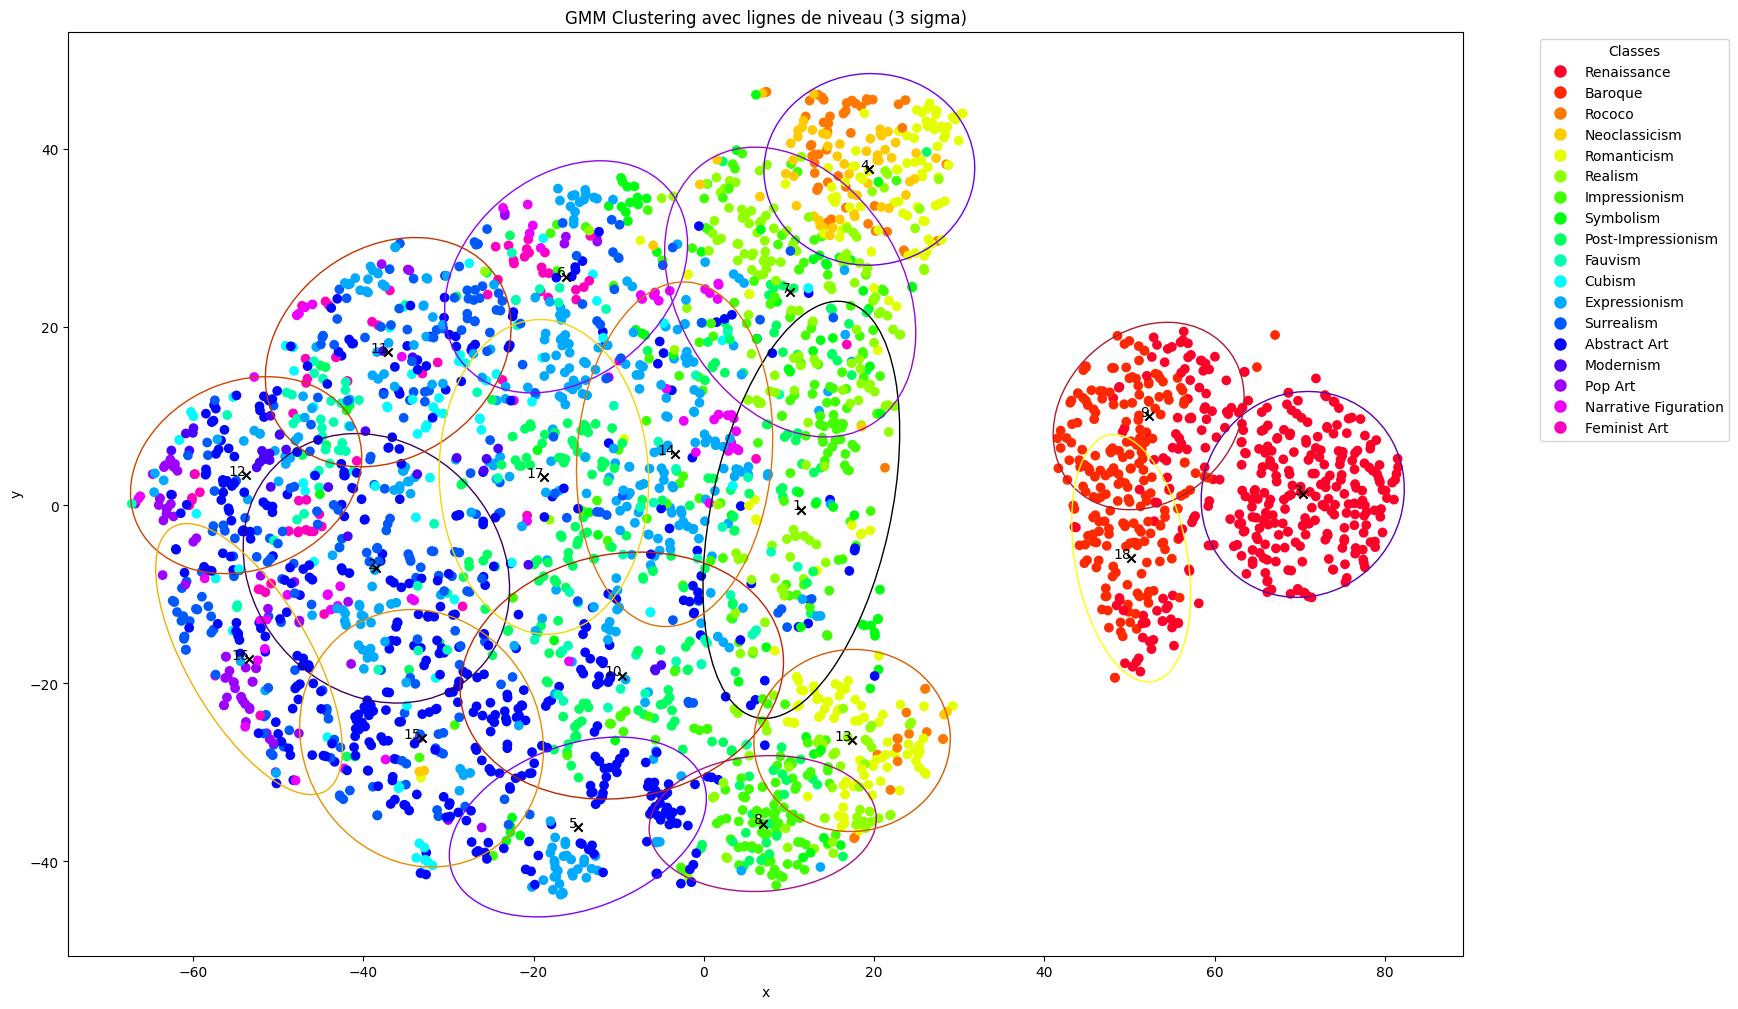

In [ ]:
n_component = num_classes

colors = plt.cm.gist_rainbow(np.linspace(0, 1, num_classes))
color_gmm = plt.cm.gnuplot(np.linspace(0, 1, n_component))

labels_bis = [painter_to_movement_idx[painter] for painter in df['painter']]
labels_bis = np.array(labels_bis)

gmm = GaussianMixture(n_components=n_component, random_state=1)

X = np.array(list(zip(features_tsne[:, 0], features_tsne[:, 1])))

gmm.fit(X)
labels = gmm.predict(X)

means = gmm.means_
covariances = gmm.covariances_

fig, ax = plt.subplots(figsize=(18, 12))
ax.scatter(X[:, 0], X[:, 1], color=colors[labels_bis], marker='o')
ax.scatter(means[:, 0], means[:, 1], c='black', marker='x')

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=all_movements[i])
                   for i in range(num_classes)]

i=0
for mean, cov in zip(means, covariances):
    plot_gaussian_ellipse(mean, cov, ax, n_std=2, edgecolor=color_gmm[i])
    i+=1
    ax.text(mean[0], mean[1], str(i), fontsize=10, ha='right')


ax.set_title('GMM Clustering avec lignes de niveau (3 sigma)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(handles=legend_elements, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')


Let's try to plot a black dot on this map to see where our Guillaumin's painting land.

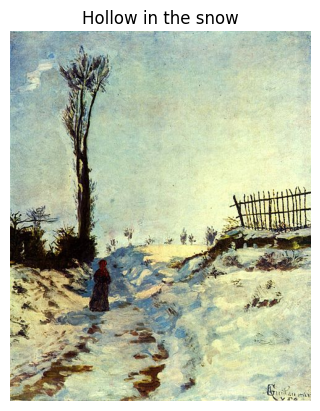


Coordonnées t-SNE du nouveau point X_new :
 [1.67251304 2.33924305]
The point is within the ellipsis : 14
The closest mean is: 14
The closest ellipsis is : 14 


In [ ]:
path = '/content/drive/My Drive/IMA206-Projet/hollow-in-the-snow-1869.jpg'
image = Image.open(path)

plt.imshow(image)
plt.title('Hollow in the snow')
plt.axis('off')
plt.show()

img_tensor, _ = format_image(path)

features = []
labels = []
model.eval()



with torch.no_grad():
  img_tensor = img_tensor.to(device)
  outputs = model(img_tensor)
  features.append(outputs)

features = torch.cat(features)
features = features.cpu().numpy()

features_b = np.zeros((1, 101))

for j in range(100) :
  features_b[0,j] = features[0,j]
features_b[0,-1] = 1841/10

X_new_tsne = calculate_tsne_point(features_birth, features_b, tsne)

print("\nCoordonnées t-SNE du nouveau point X_new :\n", X_new_tsne)
point_within_ellipsis = False
mahalanobis_distances = []
index = 0
for mean, covariance in zip(means_m, covariances_m):
    index+=1
    md = mahalanobis_distance(X_new_tsne, mean, covariance)
    mahalanobis_distances.append(md)
    if md <= 2:
        point_within_ellipsis = True
        print(f"The point is within the ellipsis : {index}")

if not point_within_ellipsis:
    print("The point is not within any ellipsis.")


distances = [euclidean_distance(X_new_tsne, mean) for mean in means_m]
closest_mean_index = np.argmin(distances)
closest_mean = means_m[closest_mean_index]

print(f"The closest mean is: {closest_mean_index+1}")
closest_ellipsis_index = np.argmin(mahalanobis_distances)
closest_ellipsis_mean = means_m[closest_ellipsis_index]
closest_ellipsis_covariance = covariances_m[closest_ellipsis_index]

print(f"The closest ellipsis is : {closest_ellipsis_index+1} ")

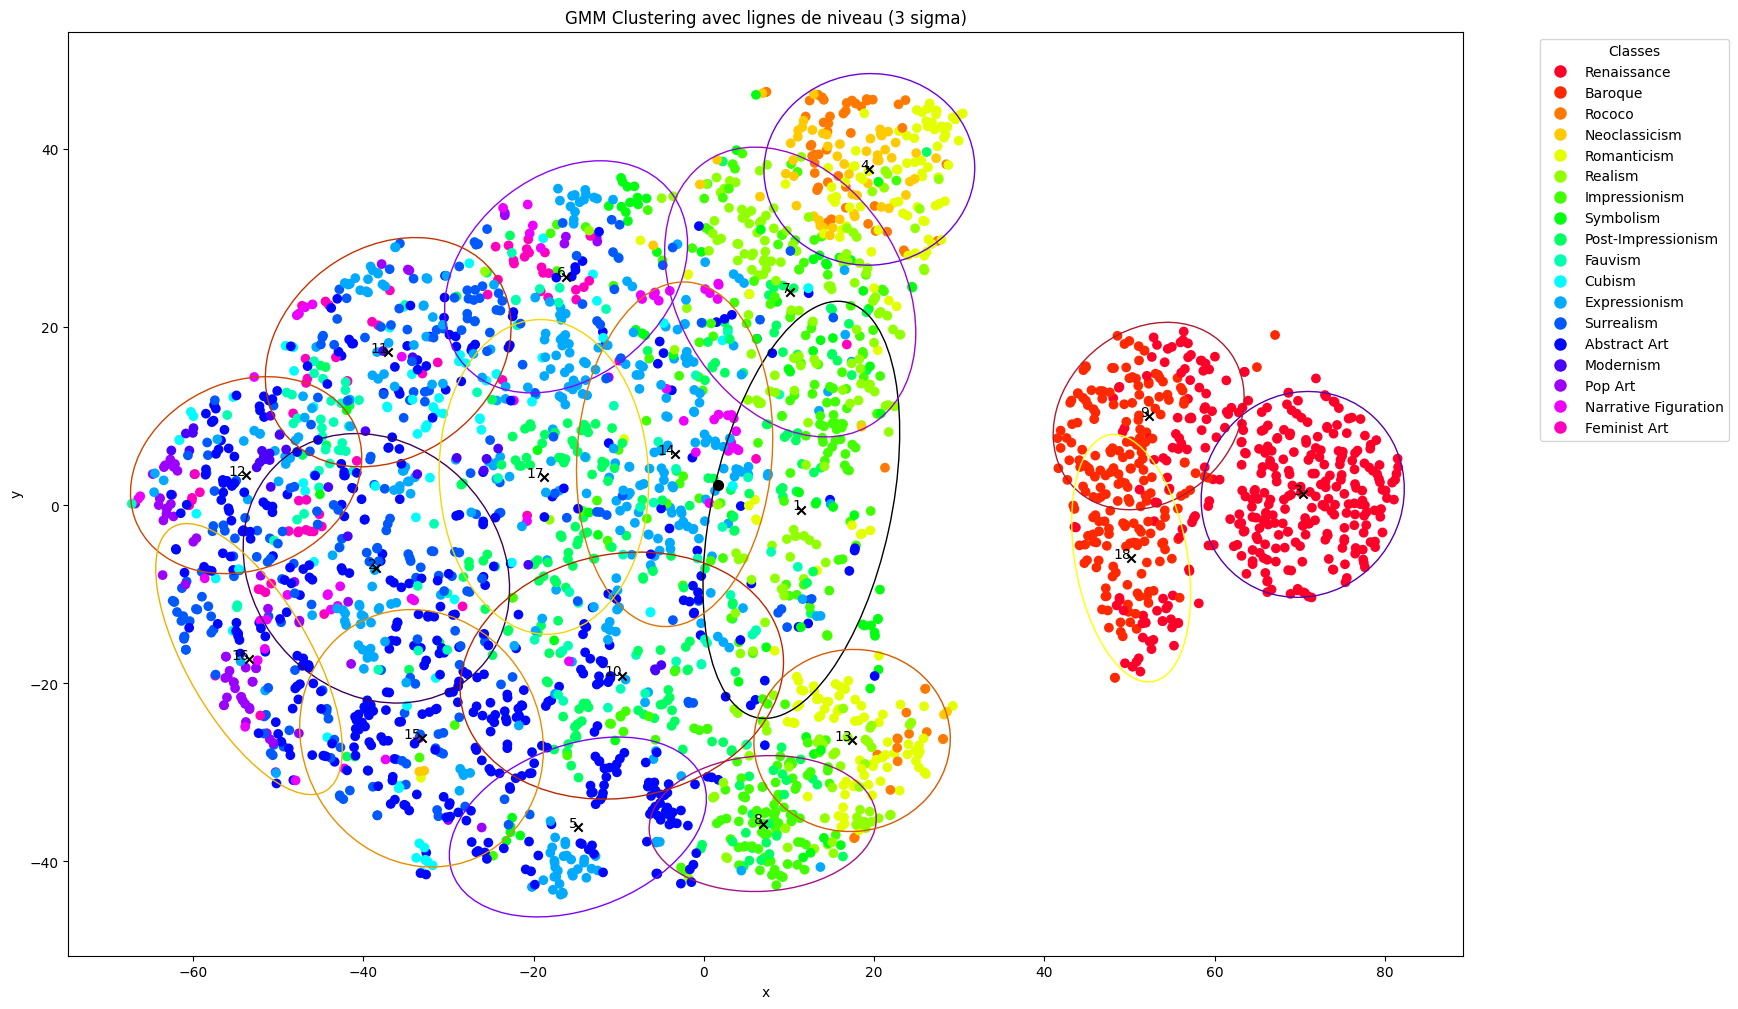

In [ ]:
n_component = num_classes

colors = plt.cm.gist_rainbow(np.linspace(0, 1, num_classes))
color_gmm = plt.cm.gnuplot(np.linspace(0, 1, n_component))

labels_bis = [painter_to_movement_idx[painter] for painter in df['painter']]
labels_bis = np.array(labels_bis)

gmm = GaussianMixture(n_components=n_component, random_state=1)

X = np.array(list(zip(features_tsne[:, 0], features_tsne[:, 1])))

gmm.fit(X)
labels = gmm.predict(X)

means = gmm.means_
covariances = gmm.covariances_

fig, ax = plt.subplots(figsize=(18, 12))
ax.scatter(X[:, 0], X[:, 1], color=colors[labels_bis], marker='o')
ax.scatter(means[:, 0], means[:, 1], c='black', marker='x')

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=all_movements[i])
                   for i in range(num_classes)]

i=0
for mean, cov in zip(means, covariances):
    plot_gaussian_ellipse(mean, cov, ax, n_std=2, edgecolor=color_gmm[i])
    i+=1
    ax.text(mean[0], mean[1], str(i), fontsize=10, ha='right')

plt.scatter(X_new_tsne[0], X_new_tsne[1], s=50, c='black', label='Special Point')  # Adjust size and color as needed

ax.set_title('GMM Clustering avec lignes de niveau (3 sigma)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(handles=legend_elements, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')


We now try to plot some work of arts that are close to the Guillaumin's picture.

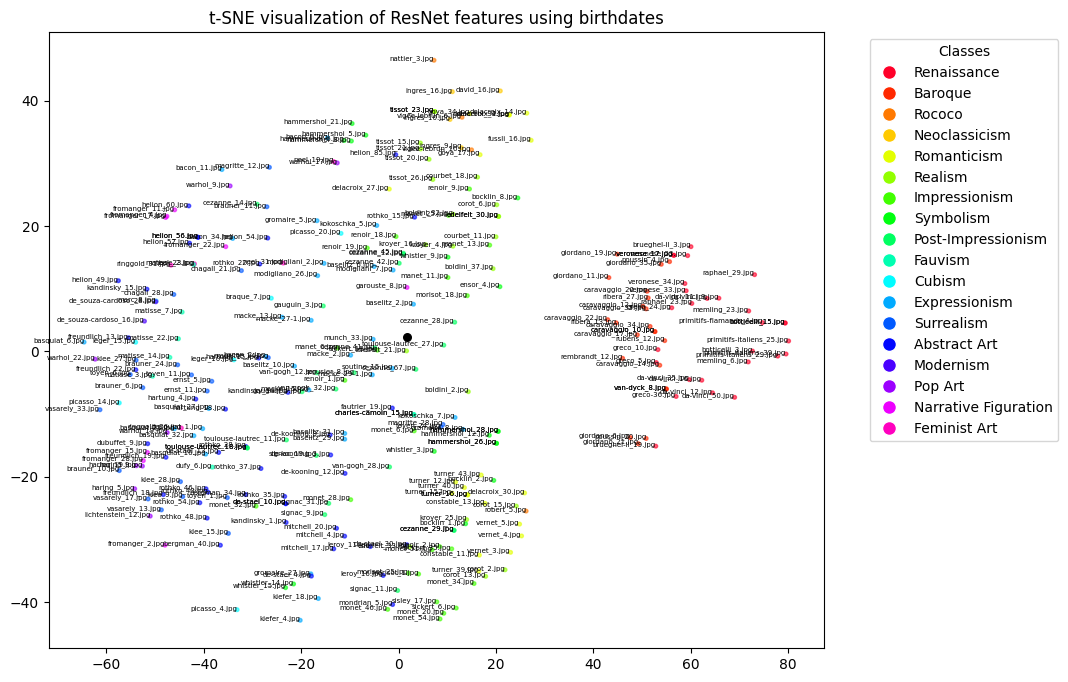

In [ ]:
colors = plt.cm.gist_rainbow(np.linspace(0, 1, num_classes))

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=all_movements[i])
    for i in range(num_classes)
]

plt.figure(figsize=(10, 8))
labels = [painter_to_movement_idx[painter] for painter in df['painter']]
labels = np.array(labels)
# Create scatter plot
indexes = np.random.randint(0,3060, size = 300)
scatter = plt.scatter(features_tsne[indexes, 0], features_tsne[indexes, 1], s=7, c=colors[labels[indexes]], alpha=0.6)

# Annotate points with image names
for i in indexes:
    plt.text(features_tsne[i, 0], features_tsne[i, 1], df['image_name'].iloc[i], fontsize=5, ha='right')

plt.scatter(X_new_tsne[0], X_new_tsne[1], s=30, c='black')

plt.title('t-SNE visualization of ResNet features using birthdates')
plt.legend(handles=legend_elements, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Final Result

For the Final Result, we try to plot the most represented label in each ellipsis to label the Guillaumin's picture.


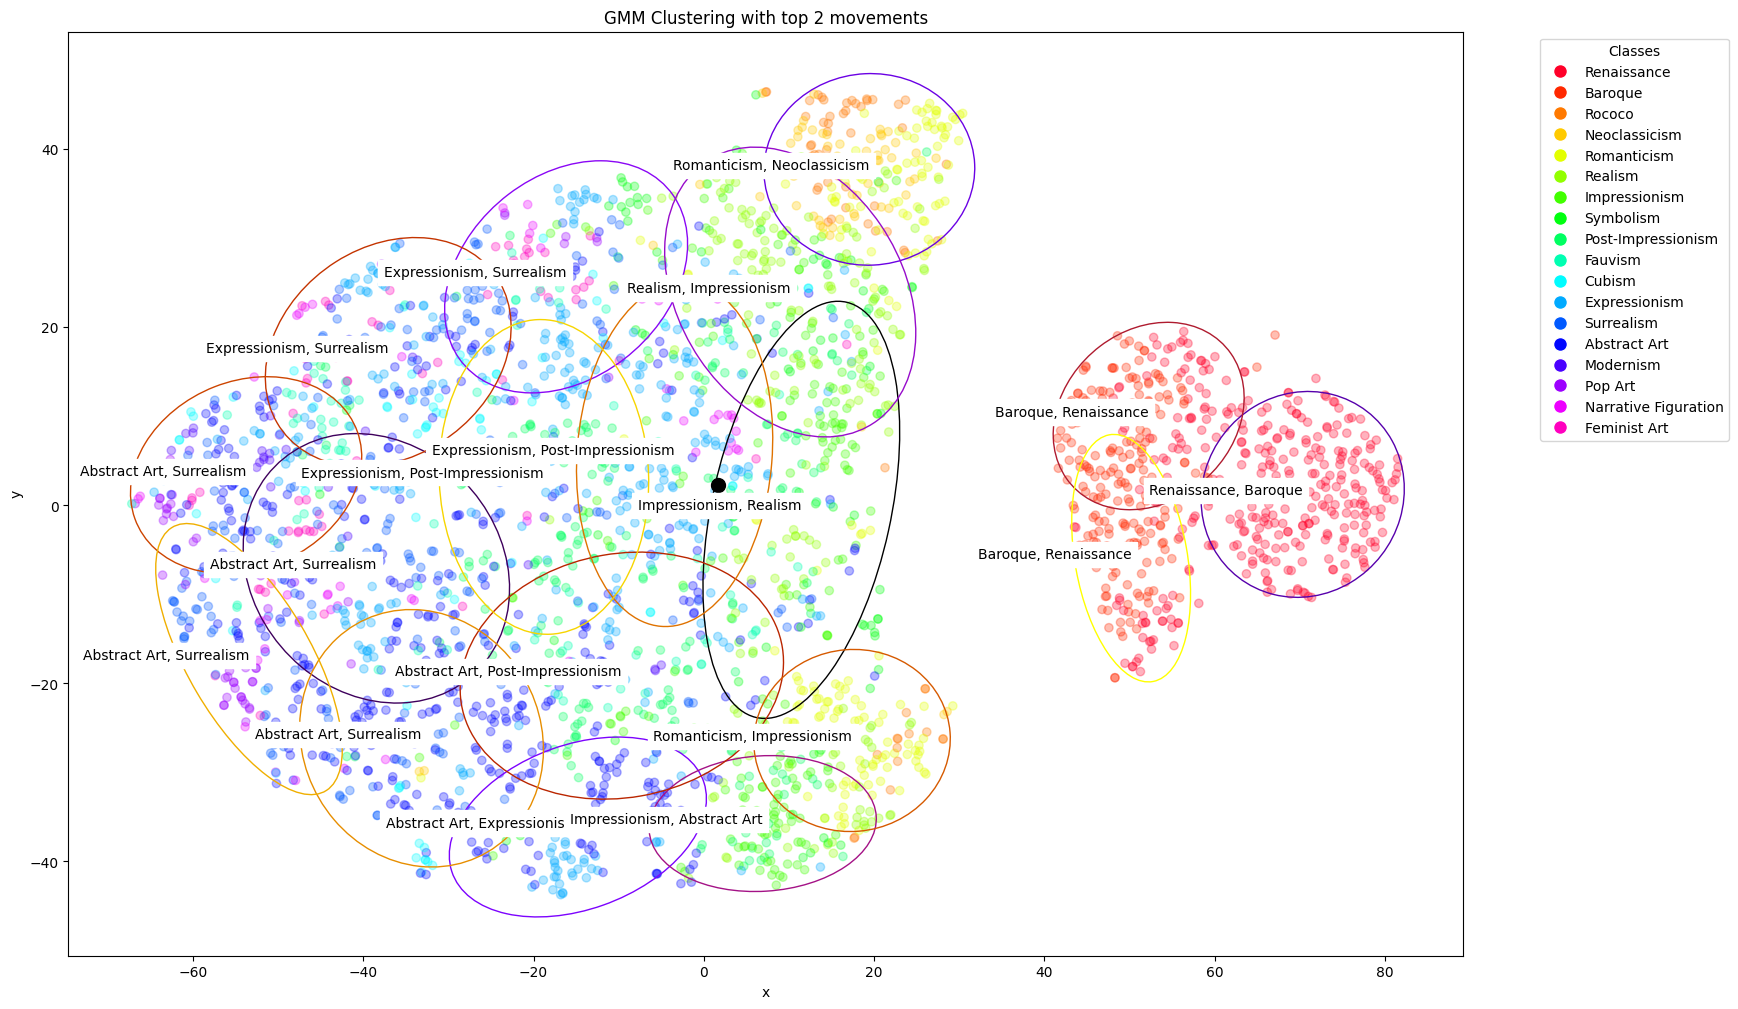

In [ ]:
threshold = chi2.ppf(0.95, df=2)
labels_bis = np.array([painter_to_movement_idx[painter] for painter in df['painter']])

N = 2  # Number of top classes to label each mean with
movements_within_ellipsis = []
for mean, cov in zip(means, covariances):
    points_within = []
    for i in range(features_tsne.shape[0]):
        if mahalanobis_distance(features_tsne[i], mean, cov) <= np.sqrt(threshold):
            points_within.append(labels_bis[i])

    movement_counts = np.bincount(points_within, minlength=num_classes)
    top_movements_indices = movement_counts.argsort()[-N:][::-1]  # Indices of the top N movements
    top_movements = [all_movements[i] for i in top_movements_indices]
    movements_within_ellipsis.append(top_movements)

# Plot the results
fig, ax = plt.subplots(figsize=(18, 12))
ax.scatter(features_tsne[:, 0], features_tsne[:, 1], color=colors[labels_bis], marker='o', alpha = 0.3)
ax.scatter(means[:, 0], means[:, 1], c='black', marker='x')

for i, (mean, cov) in enumerate(zip(means, covariances)):
    plot_gaussian_ellipse(mean, cov, ax, n_std=2, edgecolor=color_gmm[i])
    ax.text(mean[0], mean[1], ', '.join(movements_within_ellipsis[i]), fontsize=10, ha='right',backgroundcolor = 'w')

plt.scatter(X_new_tsne[0], X_new_tsne[1], s=100, c='black')

plt.title(f'GMM Clustering with top {N} movements')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(handles=legend_elements, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


We can see that the picture landed in a Impressionism/Post-Impressionism area which is satisfactory knowing the Guillaumin's picture is refered in litterature as a 'Impressionism' one.